In [423]:
import h5py 
import sys, warnings

import numpy as np 
import numpy.matlib as matlib 

import matplotlib
import matplotlib.pyplot as plt 
import matplotlib.animation as animation

from extra_data import RunDirectory 

from scipy import stats 
from IPython.display import clear_output  

import logging 
logging.captureWarnings(True) 

from sklearn.mixture import GaussianMixture 

# Setting up a random generator 
def_rng = np.random.default_rng() 

## Functions

In [620]:
import xarray

def read_run_sync_trains(r, verbose=True):
    #clear_output(wait=False) 
    #sys.stderr.write(f'Processing run {r}...\n') 
    run = RunDirectory(path=f'/gpfs/exfel/d/raw/SPB/202202/p003046/r0{r}')  
    
    # The require_all=True ensures we only get trains which exist for all sources
    sel = run.select([
        ('SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD'),
        ('SPB_IRU_MOTORS/MDL/DATA_SELECT', '*'),
        ('SPB_EXP_ZYLA/CAM/1:daqOutput', 'data.image.pixels'),
    ], require_all=True)
    if(verbose):
        sel.info()
    
    intensity_sase1_extra = sel['SPB_XTD9_XGM/XGM/DOOCS:output', 'data.intensitySa1TD']    
    motors_x_extra = sel['SPB_IRU_MOTORS/MDL/DATA_SELECT', 'SPB_IRU_INJMOV_MOTOR_X.actualPosition.value']
    motors_y_extra = sel['SPB_IRU_MOTORS/MDL/DATA_SELECT', 'SPB_IRU_INJMOV_MOTOR_Y.actualPosition.value']

    # Put the data in xarray
    motor_x = motors_x_extra.xarray()
    motor_y = motors_y_extra.xarray()
    xgm = intensity_sase1_extra.xarray()
    
    agipd_frames_per_train = 202 # number of agipd frames per train
    with h5py.File(directory+'/r0'+f'{r}'+'_proc_radavg.h5') as rad: 
        radavg = rad['entry_1']['radialavg'][:]
        trainIds = rad['entry_1']['trainId'][:]
        q = rad['entry_1']['q'][:]
    
    # Reshape the arrays from the radavg file to make them by train
    radavg = radavg.reshape((-1,agipd_frames_per_train,radavg.shape[1]))
    trainIds = trainIds.reshape((-1,agipd_frames_per_train))
    # Ensure all the trains are the same length
    if (trainIds == trainIds[:,:1]).all() != True:
        raise ValueError        
    if(verbose):
        print("Reshaping of radavg successful:", (trainIds == trainIds[:,:1]).all())
    trainIds = trainIds[:,0]
    
    # Put radavg in an xarray
    radavg = xarray.DataArray(data=radavg, dims=('trainId', 'pulseNr', 'q'), 
                              coords={'trainId': trainIds, 'pulseNr': np.arange(agipd_frames_per_train), 'q': q})

    # Find trains which are common between radavg and the rest
    common_trains = np.intersect1d(intensity_sase1_extra.train_id_coordinates(), trainIds)
    if verbose:
        print("Found %d common train IDs between radavg and the rest" % len(common_trains))

    # Find the indices of the common trainIds and keep only those
    common_train_idx = np.searchsorted(intensity_sase1_extra.train_id_coordinates(),common_trains)
    motor_x = motor_x[common_train_idx]
    motor_y = motor_y[common_train_idx]
    xgm = xgm[common_train_idx]

    # Find the indices of the common trainIds for radavg    
    common_train_idx = np.searchsorted(radavg.coords['trainId'].data,common_trains)
    radavg = radavg[common_train_idx]
    
    train_ids_eq = (motor_x.coords['trainId'].data == radavg.coords['trainId'].data)
    if verbose:
        print("Train IDs all match:", train_ids_eq.all())
    
    return xgm, motor_x, motor_y, radavg

In [703]:

def sync_pulses(xgm, radavg):
    # Find out how many X-ray pulses per train

    npulses = np.sum(np.nanmean(xgm,axis=0) > 1.0)
    # For certain runs we actually receive more than 176 pulses, but the agipd will only record 176   
    npulses = min(npulses,176)
    agipd_frames_per_pulse = 176//npulses
    return xgm[:,:npulses], radavg[:,1:npulses*agipd_frames_per_pulse+1:agipd_frames_per_pulse,:]

In [659]:
def integrate_q_range(radavg, q_min = 0.73, q_max = 13, verbose=True):
    # q_min and q_max in 1/nm

    q = radavg.coords['q'].data
    q_min_idx = np.argmax(q > q_min)
    q_max_idx = np.argmax(q > q_max)
    
    if(verbose):
        print('Integrating between %g-%g 1/nm' % (q_min,q_max))   
    I = xarray.DataArray(data=np.nansum(radavg[:,:,q_min_idx:q_max_idx],axis=2), dims=('trainId', 'pulseNr'), coords={'trainId': radavg.coords['trainId'], 'pulseNr': radavg.coords['pulseNr']})
    return I

In [310]:
def linear_fit_trains(xgm, I, n=1):
    # Do a linear fit of the intensity I versus the xgm, n consecutive trains at a time
    # The default is to do one train at a time (n=1)
    slopes = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    intercept = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    R2 = np.zeros(int(np.ceil(xgm.shape[0]/n)))
    
    for i,idx in enumerate(np.arange(0,xgm.shape[0],n)):
        fit = stats.linregress(xgm.data[idx:idx+n].flatten(), I.data[idx:idx+n].flatten())
        slopes[i] = fit.slope
        intercept[i] = fit.intercept
        R2[i] = fit.rvalue**2
    return slopes, intercept, R2

In [630]:
def plot_xgm_vs_I(xgm, I, sample_trains = 4, subsample_plot = 10):

    if(np.isscalar(sample_trains)):
        # If we pass a number as sample_trains, interpret it as the number of random trains
        sample_trains = np.sort(np.random.choice(xgm.shape[0], size=sample_trains, replace=False))
    else:
       # Otherwise interpret it as the list of trains to show as a sample
        sample_trains = np.sort(np.array(sample_trains))
    
    # Plotting the scatter plots 
    fig_handle = plt.figure(figsize=(20,10)) 
    spec_handle = fig_handle.add_gridspec(nrows = 1, ncols = 2) 

    xgm_sample = xgm[sample_trains]
    I_sample = I[sample_trains]
    
    fit = stats.linregress(xgm_sample.data.flatten(), I_sample.data.flatten())
    # Plotting selected single-train AGIPD/XGM correlation 
    ax_i = fig_handle.add_subplot(spec_handle[0,0])
    for t in sample_trains:
        im_i = plt.scatter(xgm[t], I[t],s=5,label=t)
    ax_i.legend(title='Sample trains', loc='lower right')
    
    xgm_limits = np.array([xgm.min(),xgm.max()])
    ax_i.plot(xgm_limits, (fit.slope * xgm_limits + fit.intercept) , "--k", linewidth = 1) 
    ax_i.set_title('Sample Trains') 
    ax_i.set_ylabel('Integrated Intensity (ADU)') 
    ax_i.set_xlabel('XGM Pulse Energy (uJ)') 
    ax_i.annotate("$R^2$= " + str("%0.5f" % fit.rvalue**2), xy = (0.05, 0.95), 
                    xycoords = "axes fraction", size = 12); 
    
    # Plotting selected multi-train AGIPD/XGM correlation 
    fit = stats.linregress(xgm.data.flatten(), I.data.flatten())
    train = xgm.coords['trainId'].data
    # Give the train number relative to the start of the run
    train -= train[0]
    c_points = np.broadcast_to(train.reshape((-1,1)), xgm.shape)

    ax_i = fig_handle.add_subplot(spec_handle[0,1]) 
    im_i = plt.scatter(xgm[:,::subsample_plot],I[:,::subsample_plot],s=5,c=c_points[:,::subsample_plot]) 
 
    ax_i.plot(xgm_limits, (fit.slope * xgm_limits + fit.intercept) , "--k", linewidth = 1) 
    ax_i.annotate("$R^2$= " + str("%0.5f" % fit.rvalue**2), xy = (0.05, 0.95), 
                    xycoords = "axes fraction", size = 12)
    ax_i.set_title('Entire Run') 
    ax_i.set_ylabel('Integrated Intensity (ADU)') 
    ax_i.set_xlabel('XGM Pulse Energy (uJ)') 
    plt.colorbar()
    plt.show()

In [526]:
from matplotlib import colors

def plot_R2_vs_motor(R2, motor_x, motor_y, vmax=25):
    if np.std(motor_x) > np.std(motor_y):
        motor = motor_x
        axis = 'x'
    else:
        motor = motor_y
        axis = 'y'
    fig_handle = plt.figure(figsize=(20,20))
    spec_handle = fig_handle.add_gridspec(nrows = 2, ncols = 2)
    ax_i = fig_handle.add_subplot(spec_handle[0,0])
    _ = plt.hist2d(motor,R2,bins=[25,256],vmax=vmax)
    plt.xlabel('motor '+axis+' (mm)') 
    plt.ylabel('R^2') 
    plt.title('Histogram of R^2 between I and xgm per motor position')
    plt.colorbar()
    ax_i = fig_handle.add_subplot(spec_handle[0,1])
    plt.plot(R2)
    plt.xlabel('Train') 
    plt.ylabel('R^2') 
    plt.title('R^2 of the fit throughput the run')
    
    ax_i = fig_handle.add_subplot(spec_handle[1,0])
    plt.plot(motor_x)
    plt.xlabel('Train') 
    plt.ylabel('Position (mm)') 
    plt.title('Motor x position throughput the run')
    ax_i = fig_handle.add_subplot(spec_handle[1,1])
    plt.plot(motor_y)
    plt.xlabel('Train') 
    plt.ylabel('Position (mm)') 
    plt.title('Motor y position throughput the run')    
    plt.show()

In [584]:
def plot_R2_vs_slope(R2, slopes, vmax=25):
    fig_handle = plt.figure(figsize=(20,10))
    spec_handle = fig_handle.add_gridspec(nrows = 1, ncols = 2)
    ax_i = fig_handle.add_subplot(spec_handle[0,0])
    plt.scatter(slopes, R2,c=np.arange(len(R2)))
    plt.title('R2 vs Slope')
    plt.xlabel('Slope')
    plt.ylabel('R2')
#    plt.ylim([0.1,1.0])
#    plt.xlim([0,20])
    plt.colorbar()
    ax_i = fig_handle.add_subplot(spec_handle[0,1])
    plt.plot(slopes, label='Slope',zorder=1)
    plt.hlines(np.percentile(slopes,5),xmin=0,xmax=len(slopes),linestyles=':', label="5 percentile = %g" % np.percentile(slopes,5))
    plt.hlines(np.percentile(slopes,95),xmin=0,xmax=len(slopes),linestyles='--', label="95 percentile = %g" % np.percentile(slopes,95))
    plt.title('Slope of fit throughput the run')
    plt.legend(loc='upper left')
    plt.show()

In [680]:
def plot_all(runs):
    from IPython.display import display, Markdown
    for run in np.array(runs, copy=False, ndmin=1):
        display(Markdown('<hr><h1 style="text-align:center"> <font size=32>Analysis of Run %d</font></h1>' % run))
        xgm, motor_x, motor_y, radavg = read_run_sync_trains(run, verbose=False)
        xgm, radavg = sync_pulses(xgm, radavg)
        display(Markdown('<center>%d trains read and synchronized with %d pulses per train</center>' % (xgm.shape[0], xgm.shape[1])))
        I = integrate_q_range(radavg, verbose=False)
        slopes, intercept, R2 = linear_fit_trains(xgm, I, n=1)
        display(Markdown('<center><h2> Scattered vs Incident Intensity</h2></center>'))
        plot_xgm_vs_I(xgm, I, sample_trains=10)
        display(Markdown('<center><h2> Goodness of Fit Analysis</h2></center>'))
        plot_R2_vs_motor(R2, motor_x, motor_y)
        display(Markdown('<center><h2> Slope of Fit Analysis</h2></center>'))
        plot_R2_vs_slope(R2, slopes)

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 184</font></h1>

<center>3125 trains read and synchronized with 176 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

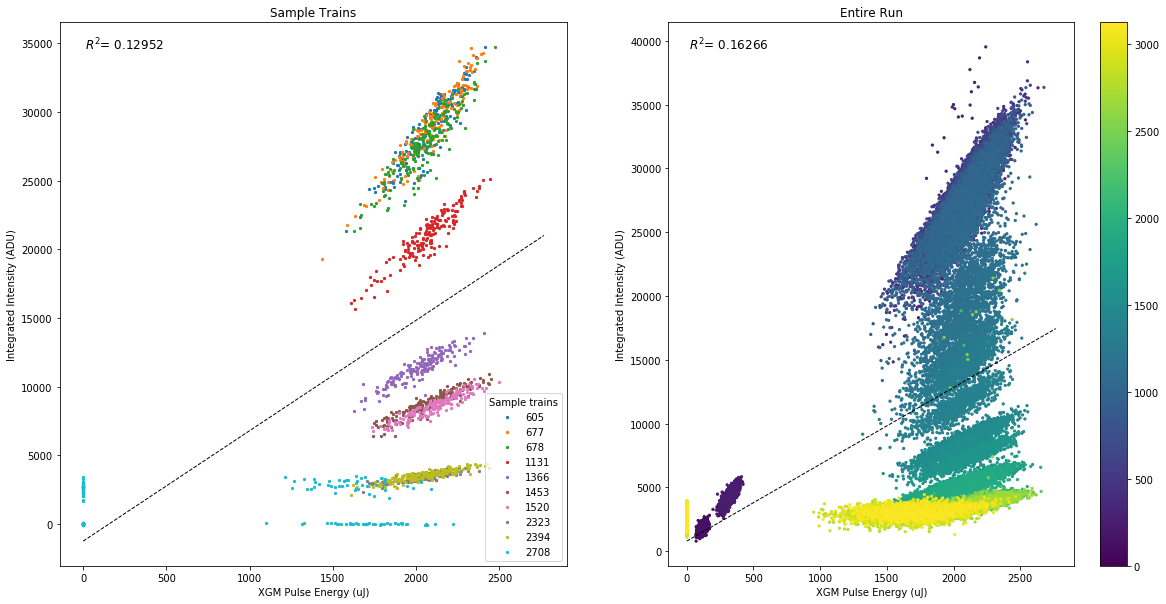

<center><h2> Goodness of Fit Analysis</h2></center>

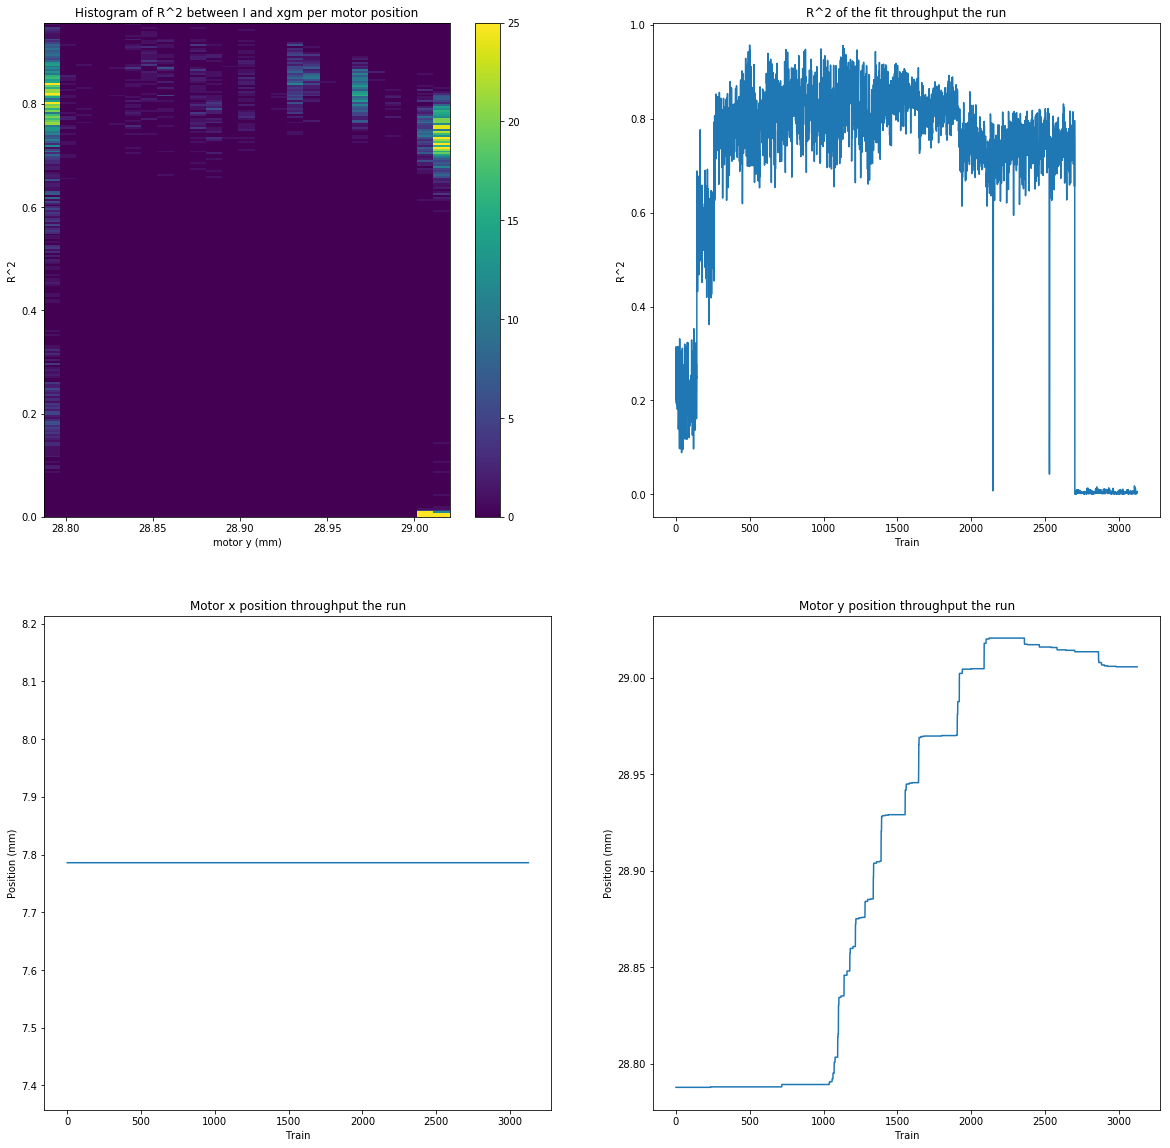

<center><h2> Slope of Fit Analysis</h2></center>

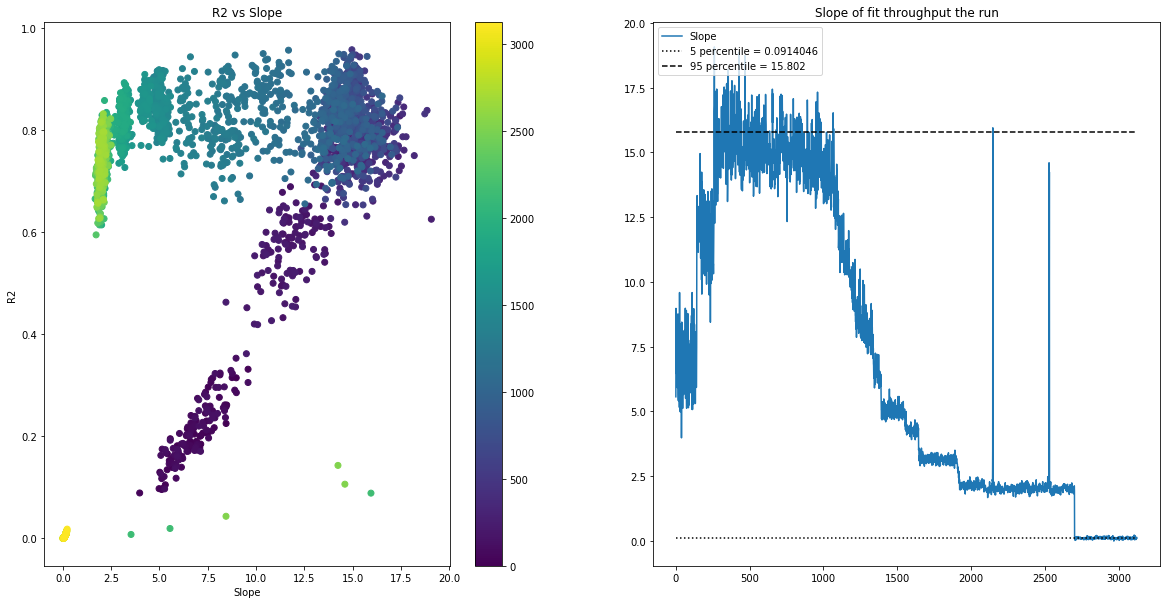

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 185</font></h1>

<center>3119 trains read and synchronized with 88 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

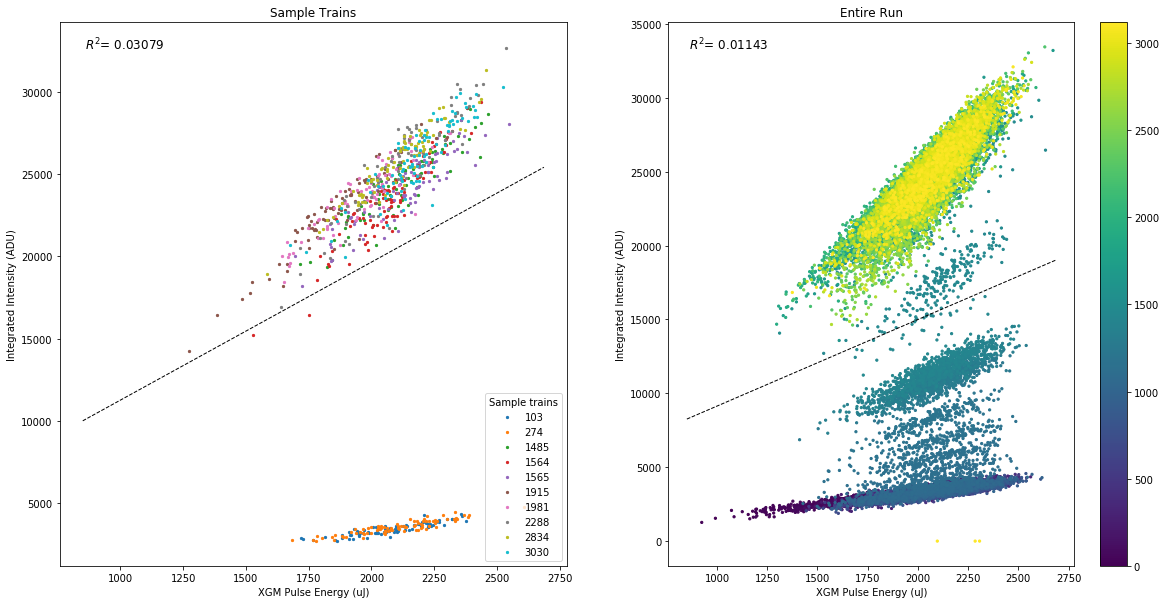

<center><h2> Goodness of Fit Analysis</h2></center>

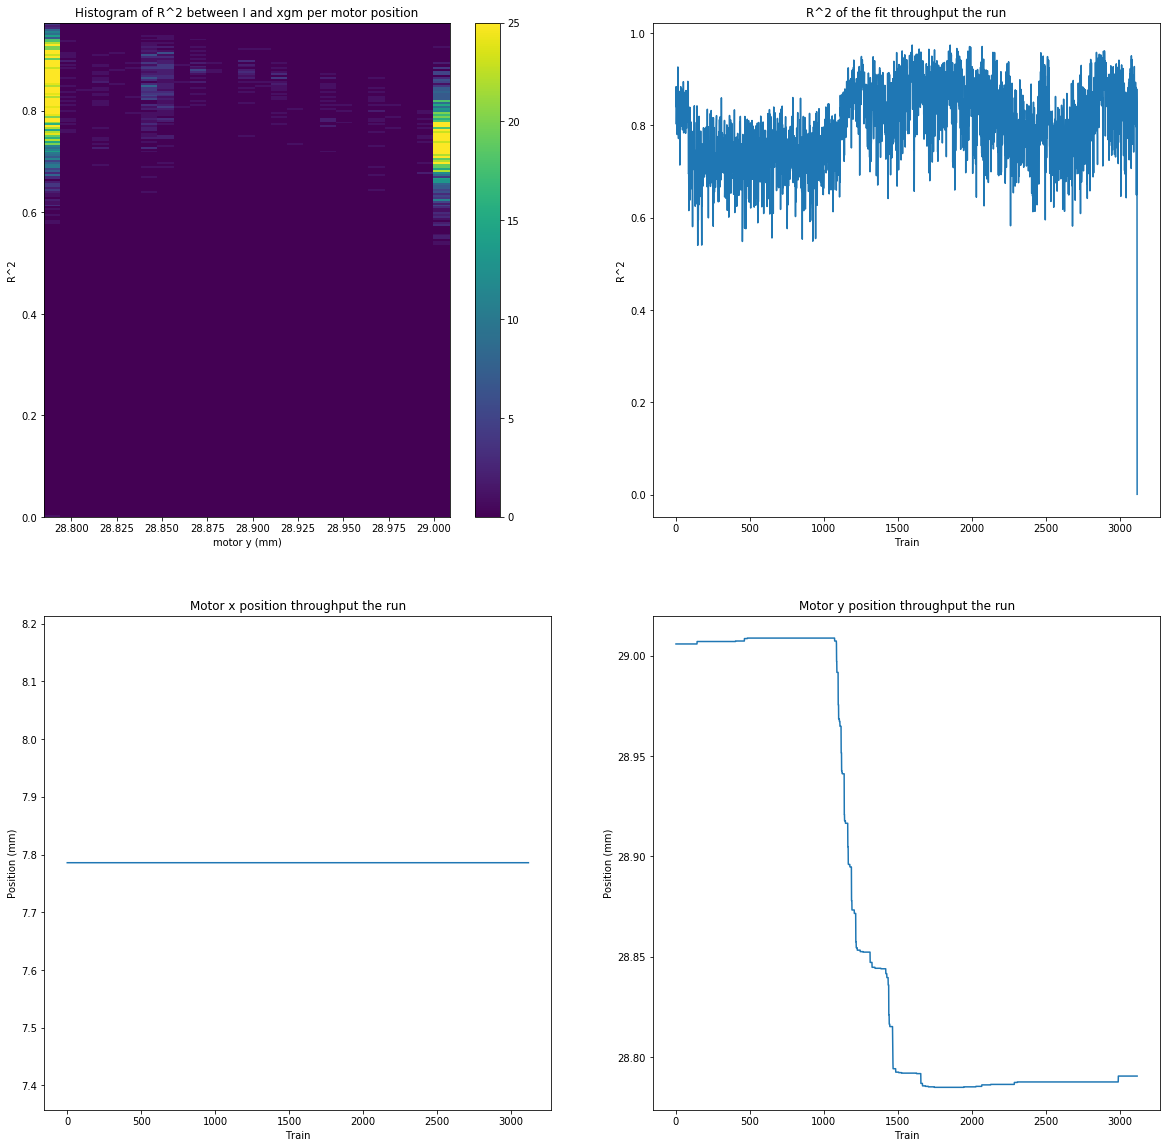

<center><h2> Slope of Fit Analysis</h2></center>

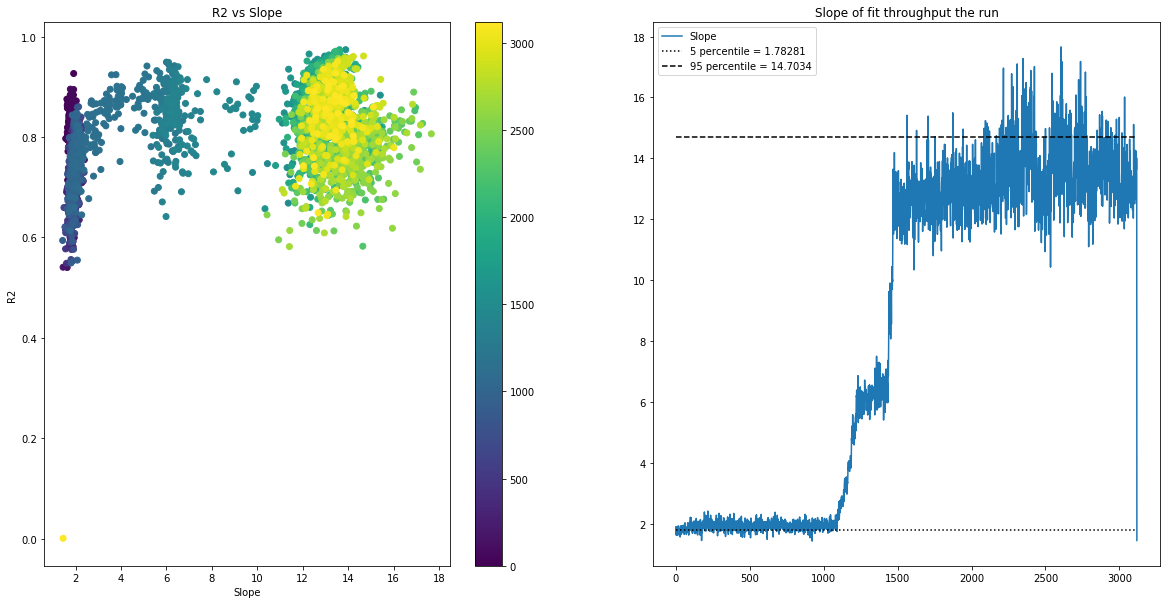

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 186</font></h1>

<center>3122 trains read and synchronized with 176 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

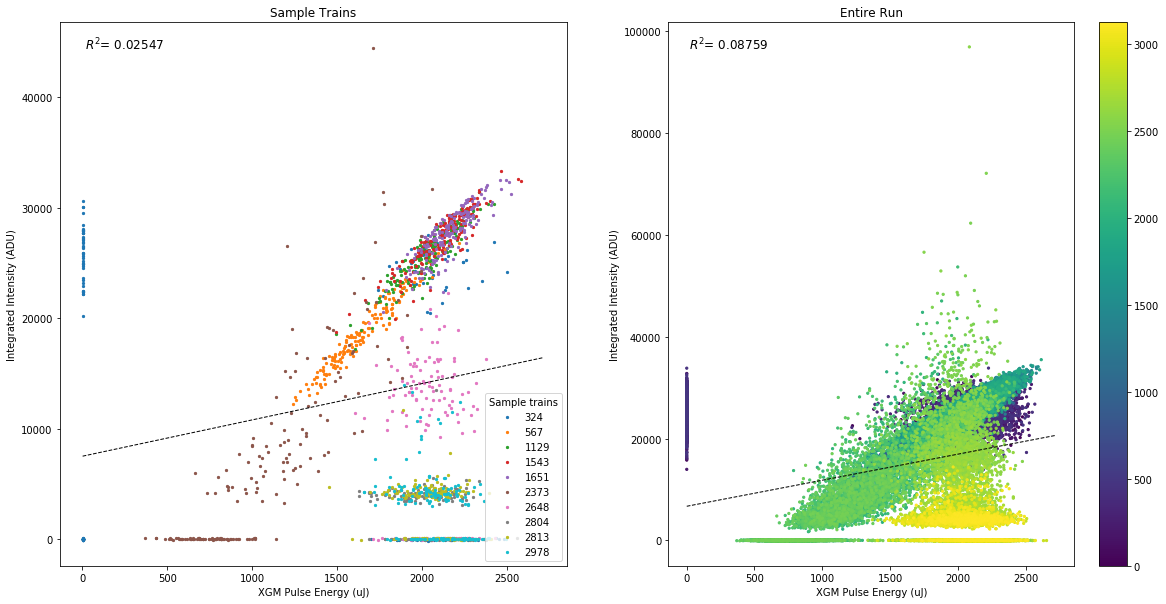

<center><h2> Goodness of Fit Analysis</h2></center>

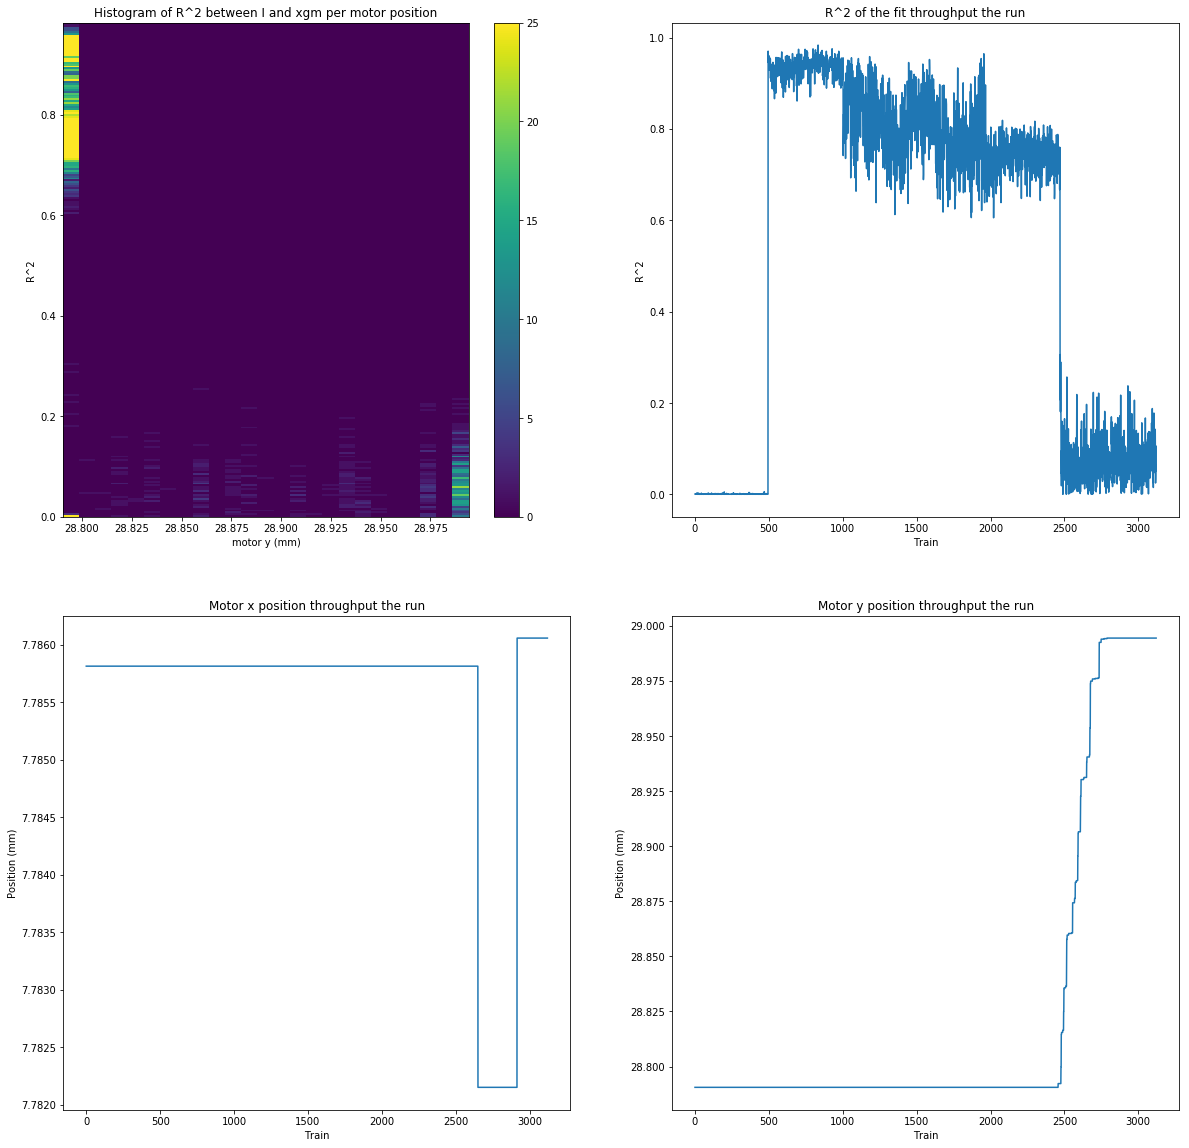

<center><h2> Slope of Fit Analysis</h2></center>

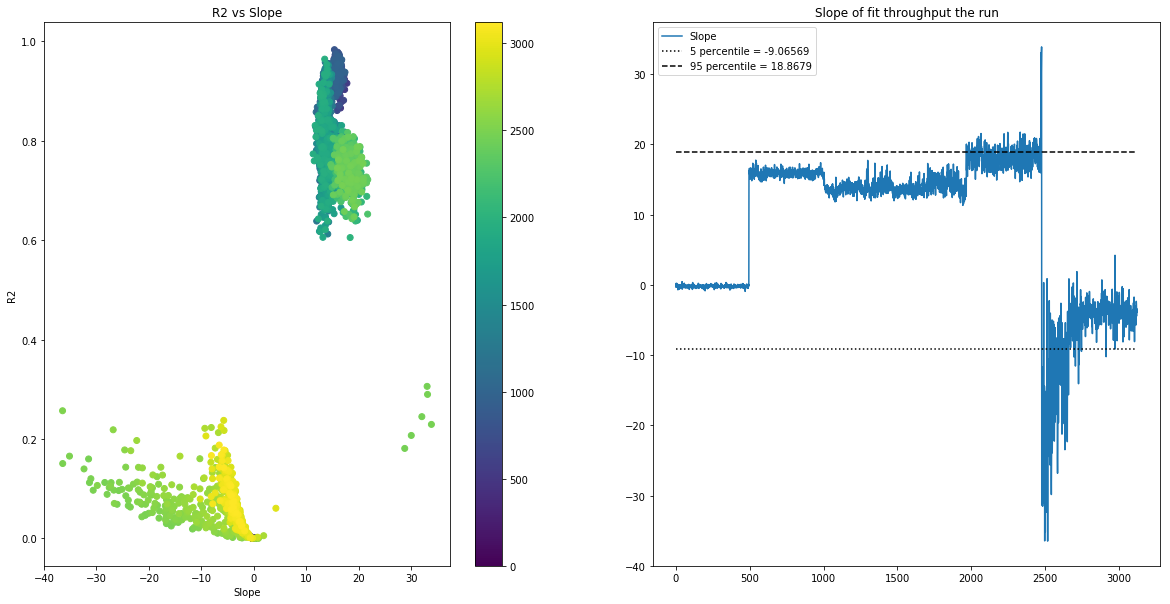

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 187</font></h1>

<center>3123 trains read and synchronized with 176 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

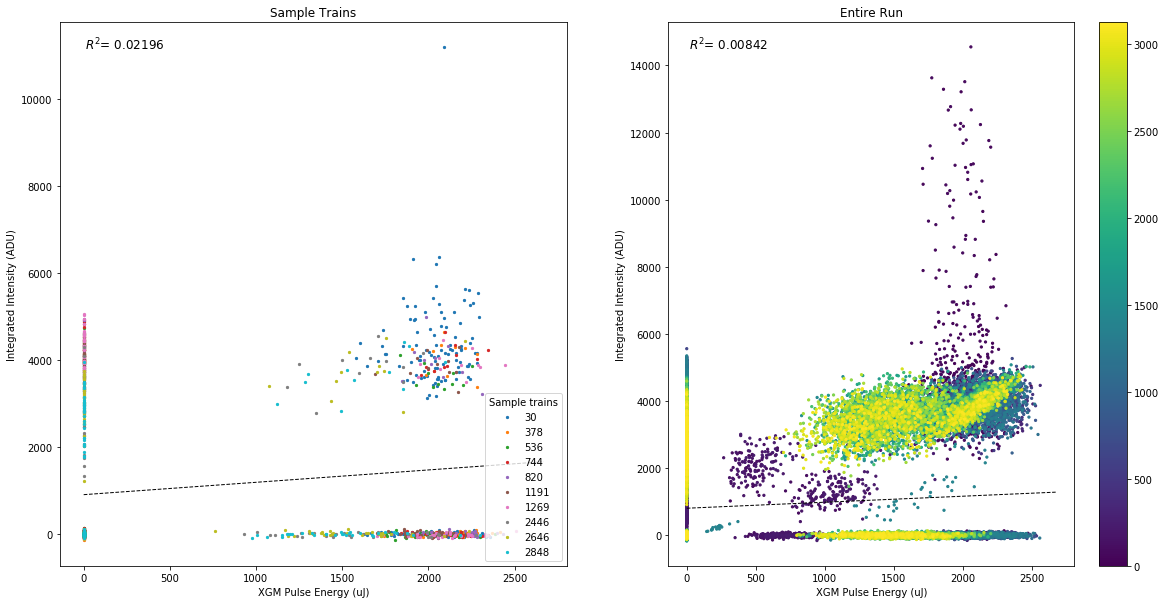

<center><h2> Goodness of Fit Analysis</h2></center>

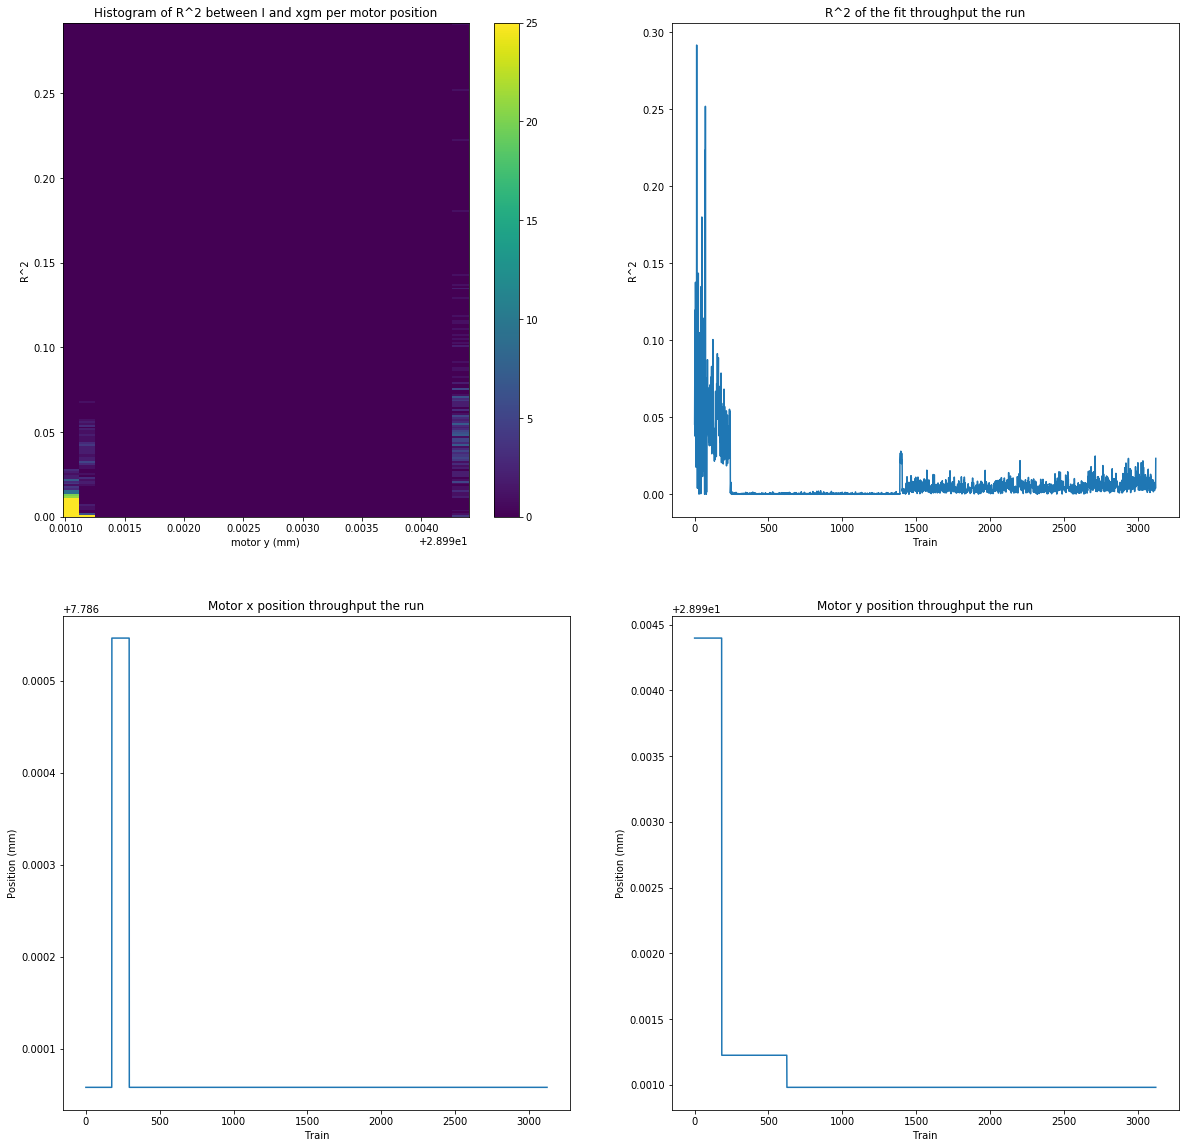

<center><h2> Slope of Fit Analysis</h2></center>

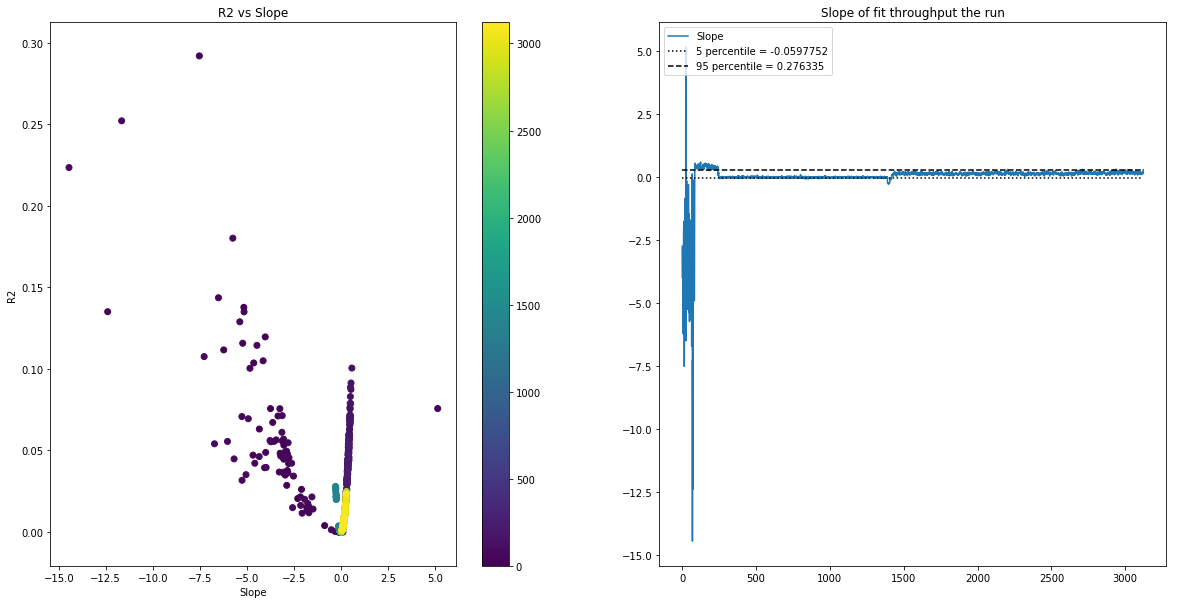

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 188</font></h1>

<center>3125 trains read and synchronized with 44 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

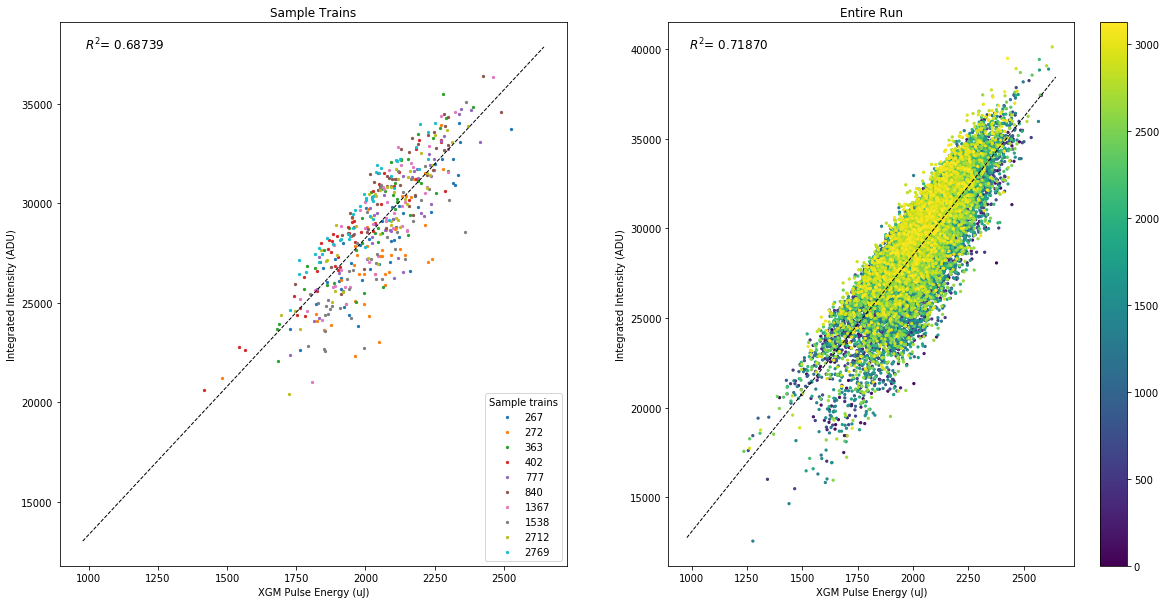

<center><h2> Goodness of Fit Analysis</h2></center>

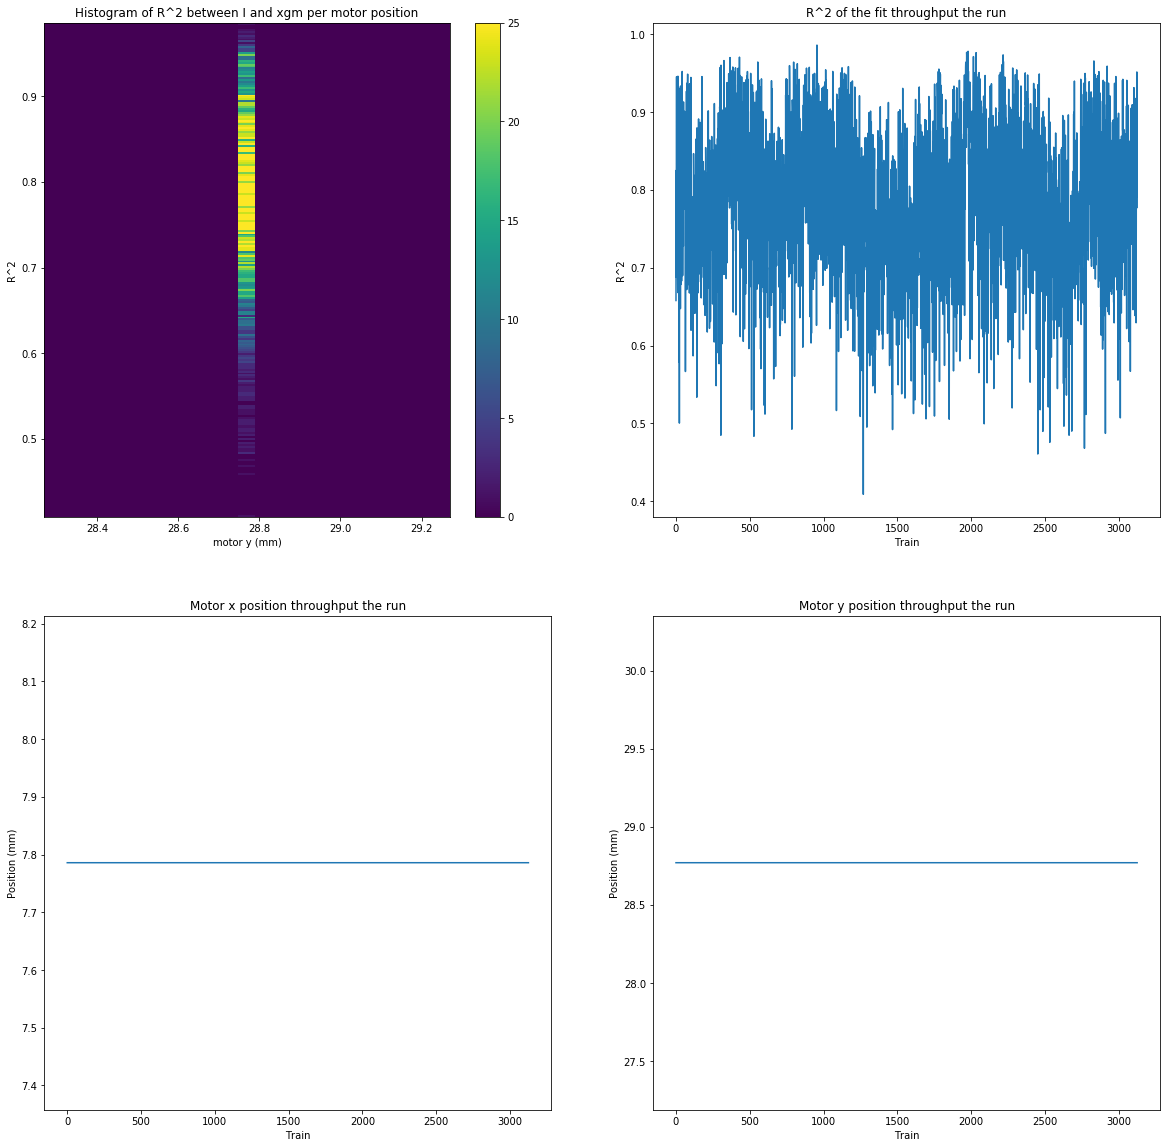

<center><h2> Slope of Fit Analysis</h2></center>

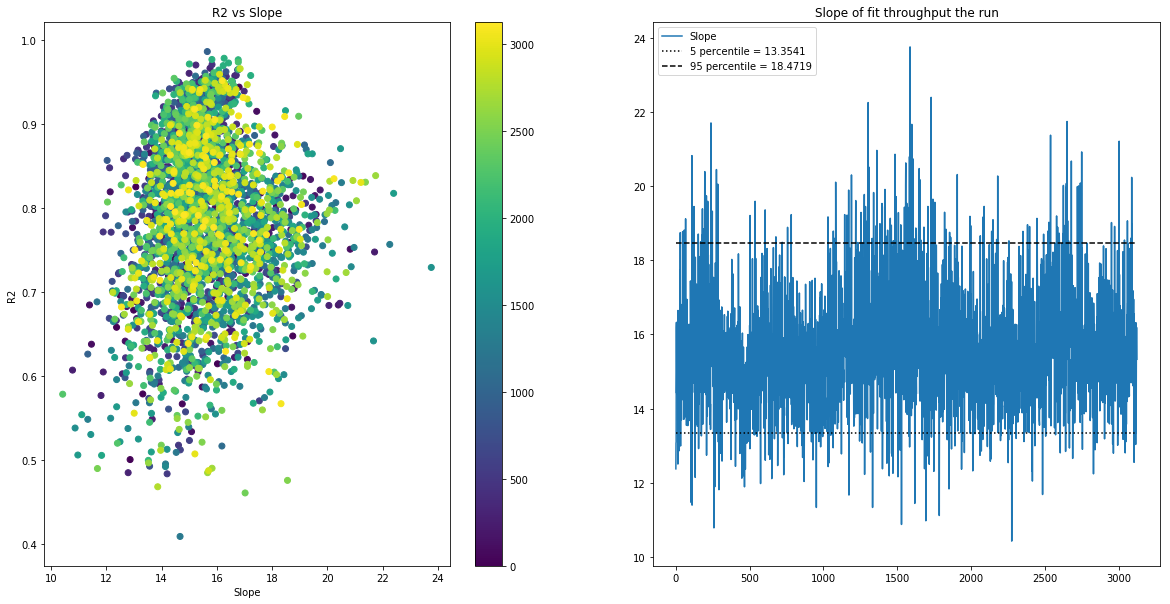

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 189</font></h1>

<center>3125 trains read and synchronized with 44 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

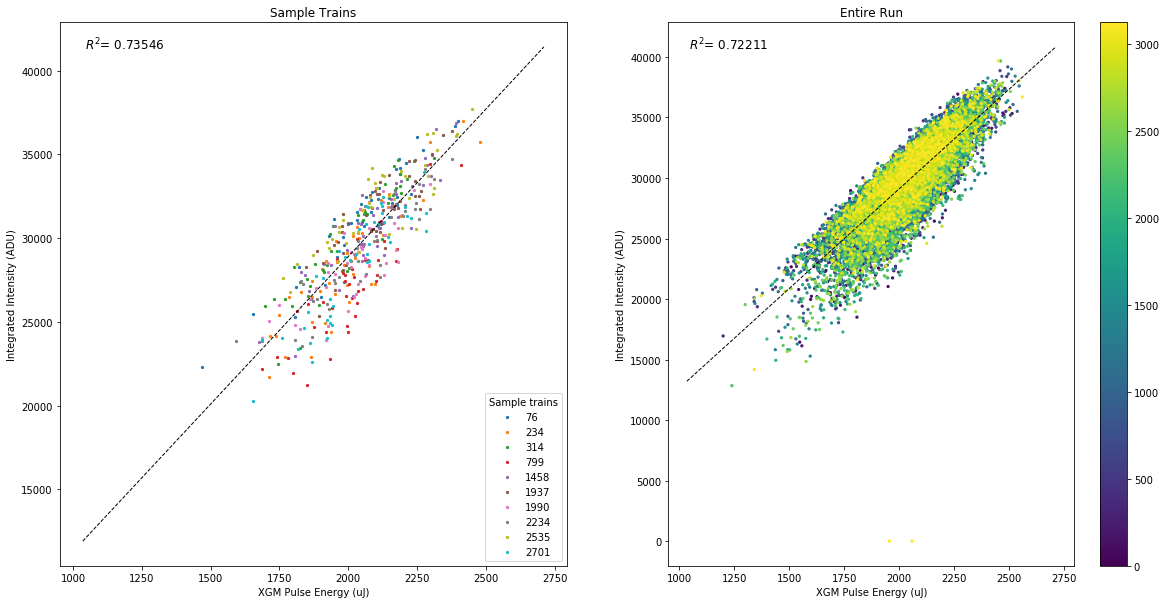

<center><h2> Goodness of Fit Analysis</h2></center>

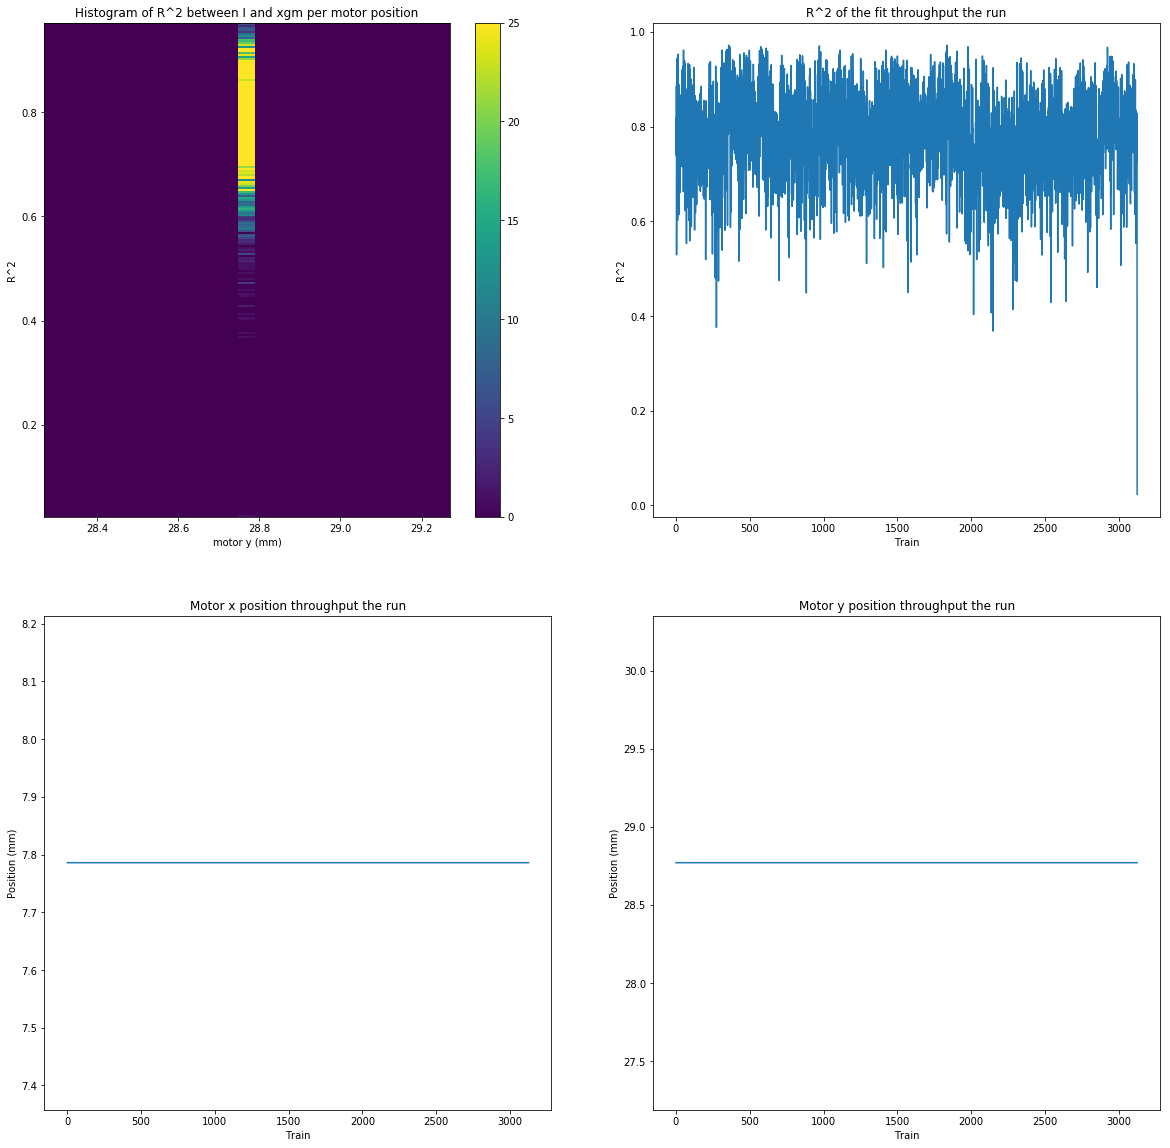

<center><h2> Slope of Fit Analysis</h2></center>

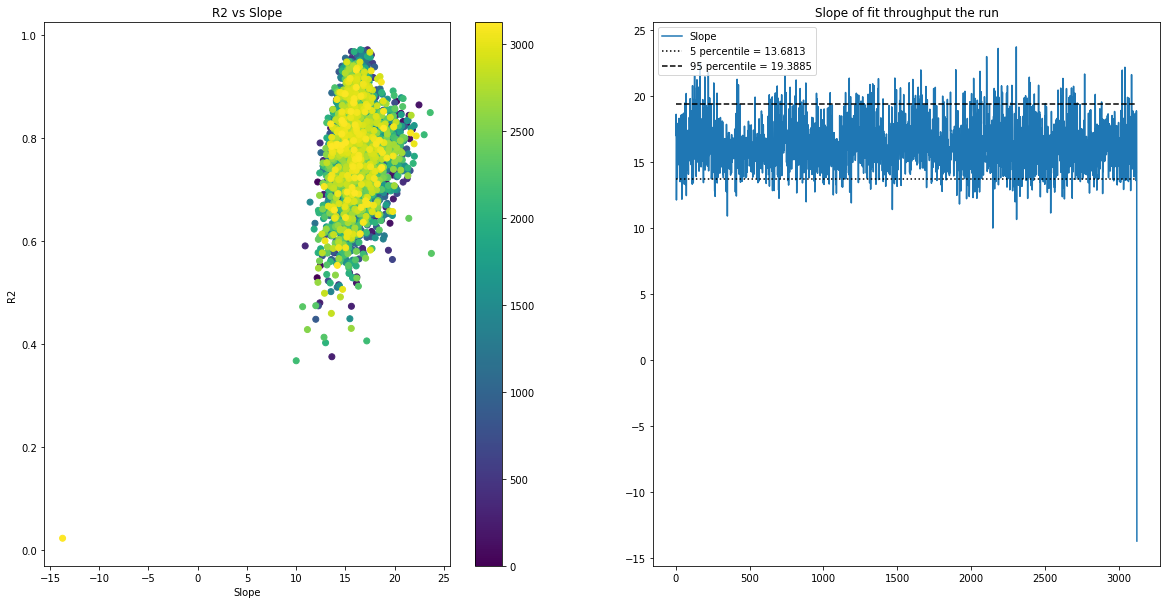

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 190</font></h1>

<center>3126 trains read and synchronized with 44 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

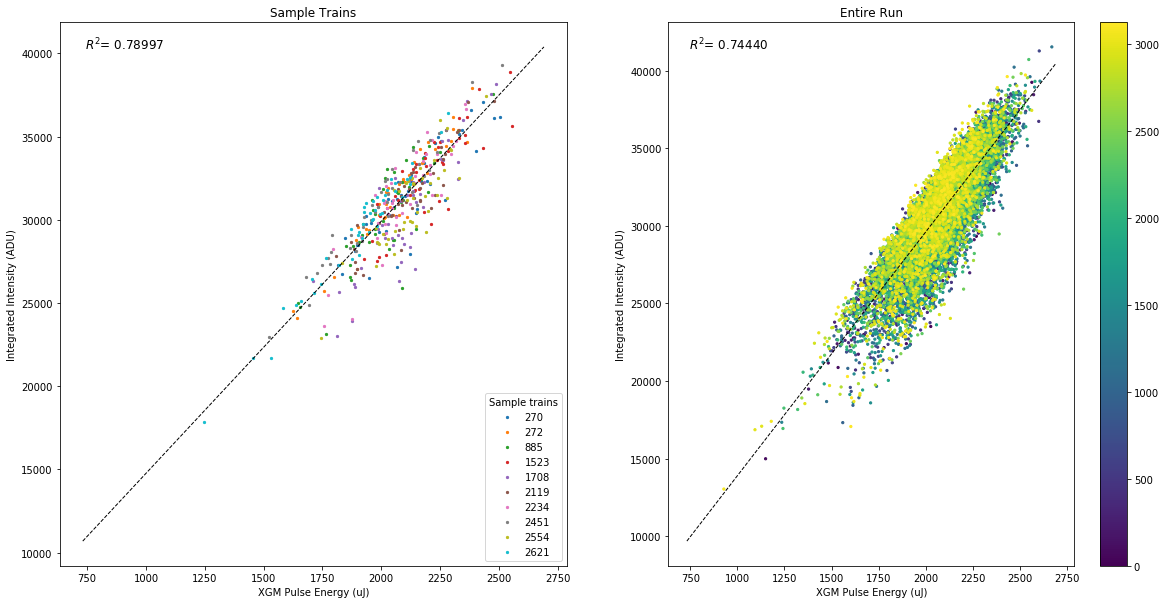

<center><h2> Goodness of Fit Analysis</h2></center>

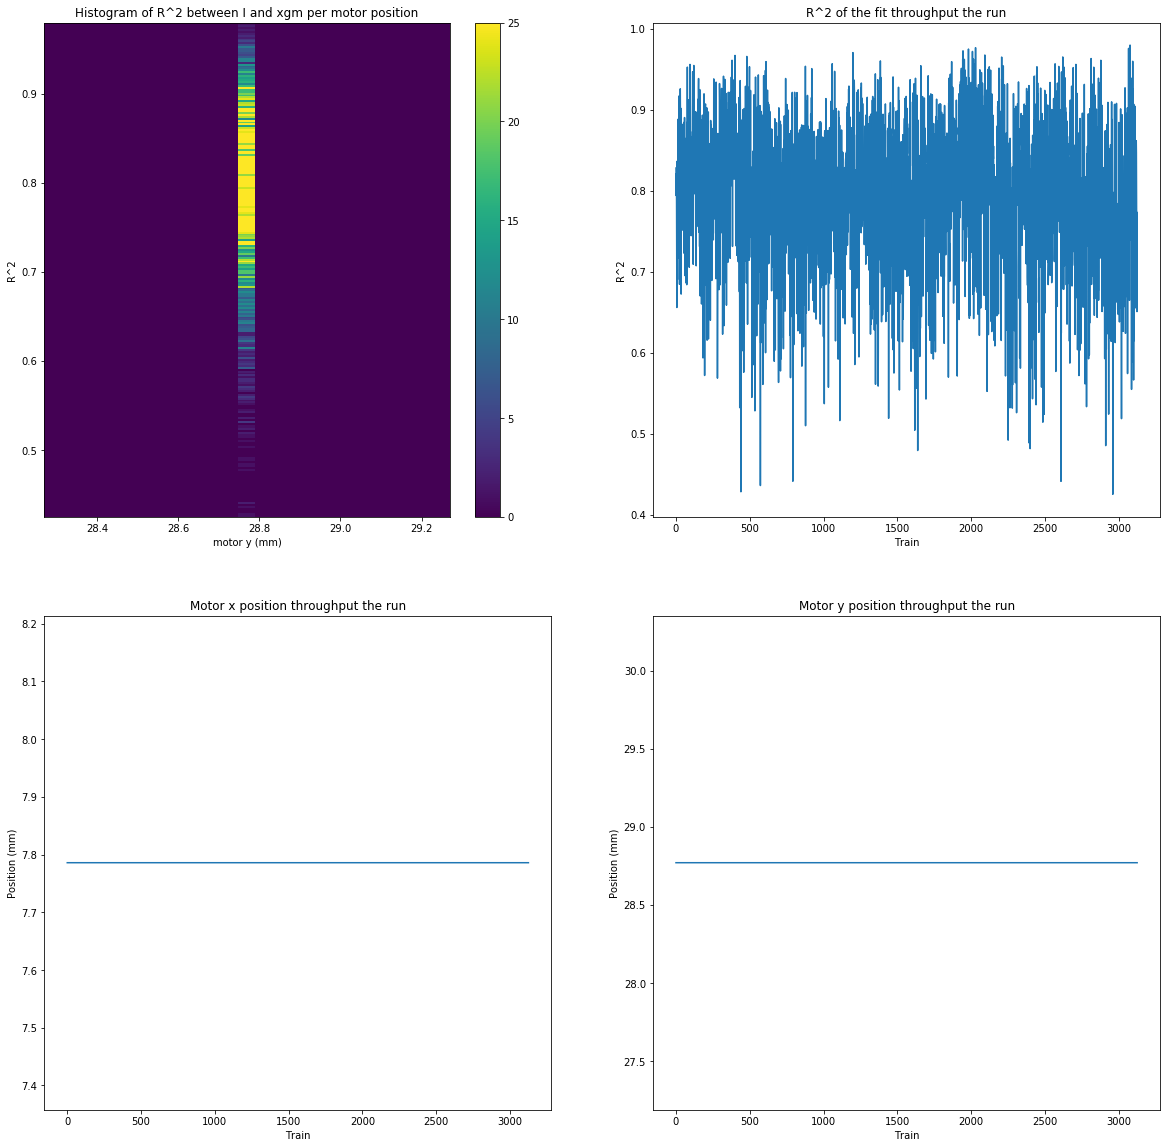

<center><h2> Slope of Fit Analysis</h2></center>

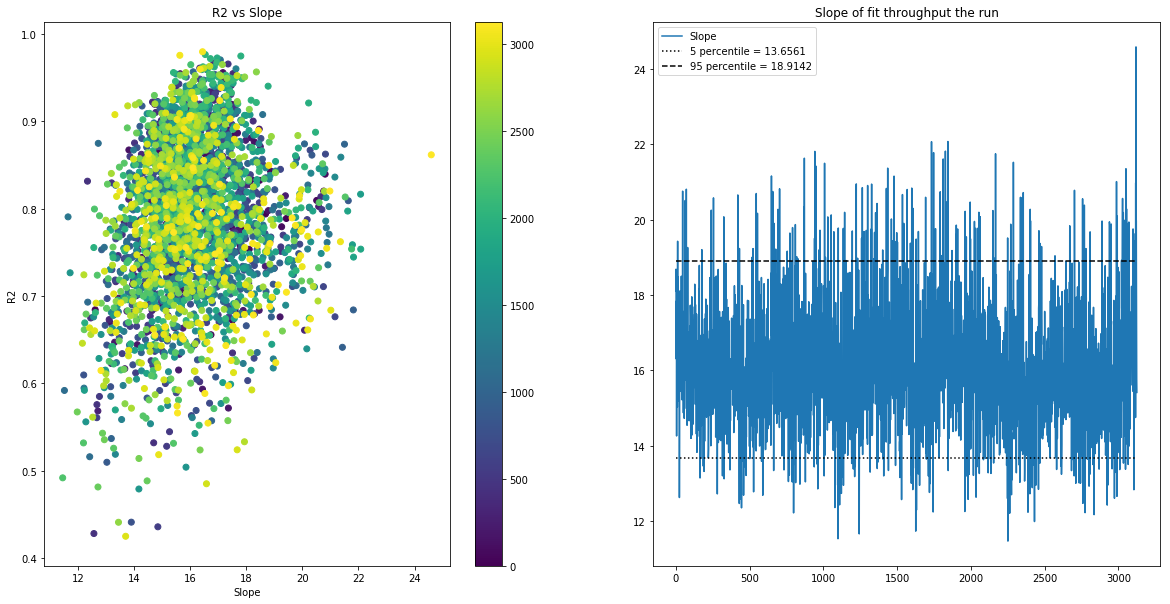

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 191</font></h1>

<center>1472 trains read and synchronized with 44 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

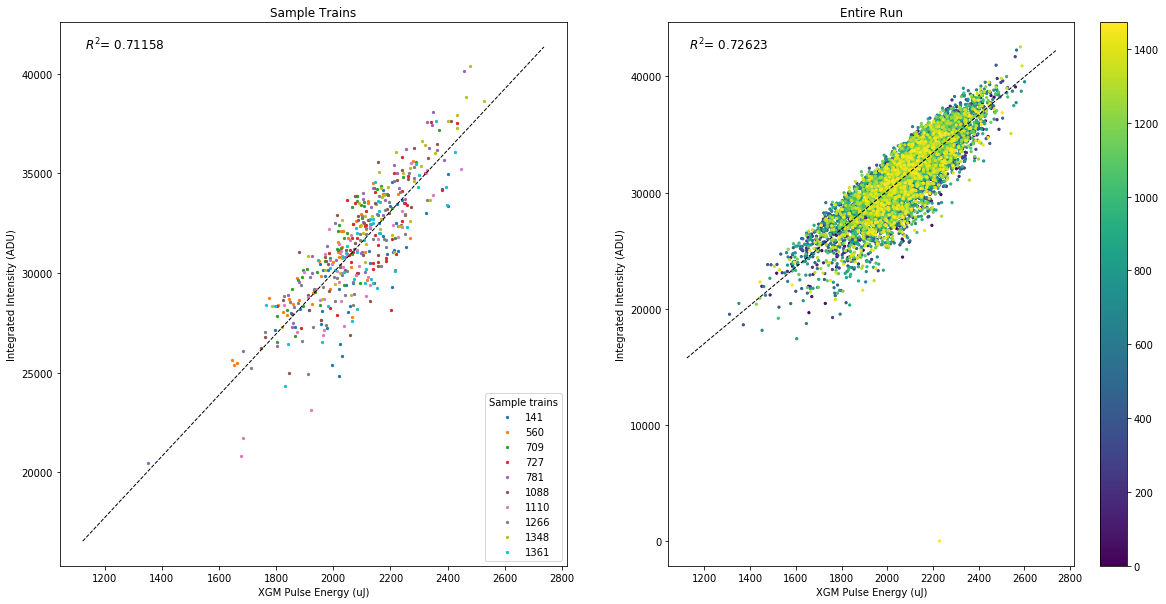

<center><h2> Goodness of Fit Analysis</h2></center>

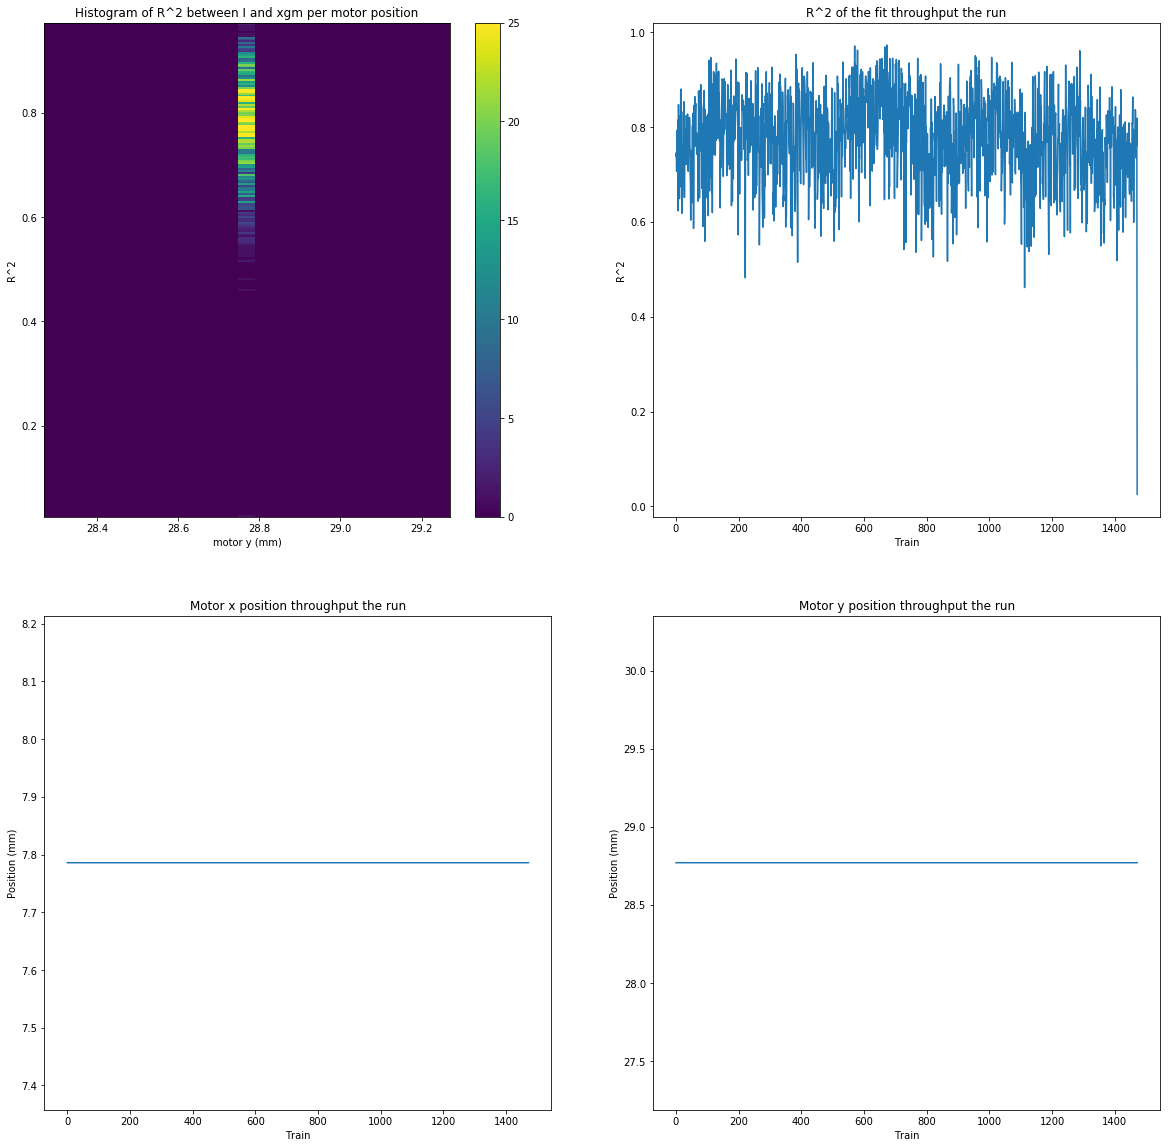

<center><h2> Slope of Fit Analysis</h2></center>

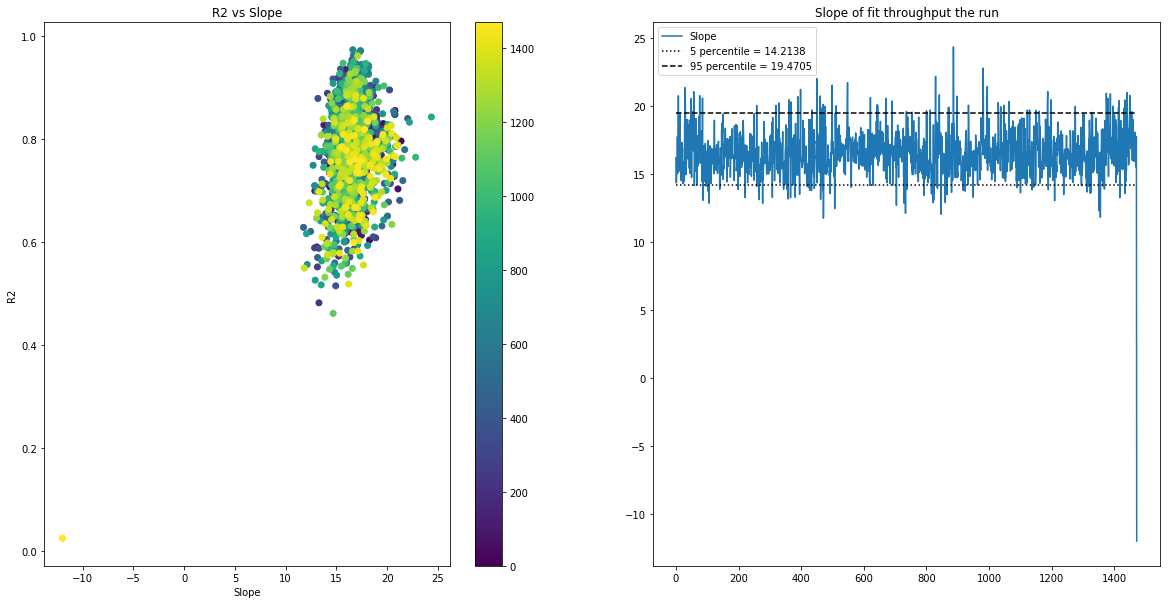

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 192</font></h1>

<center>1493 trains read and synchronized with 44 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

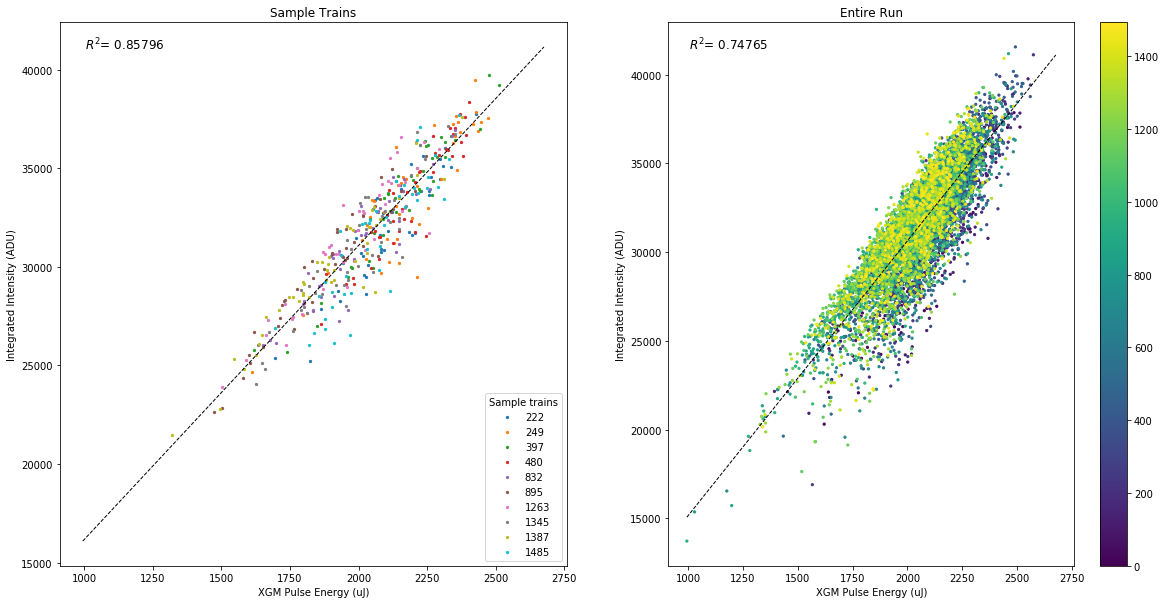

<center><h2> Goodness of Fit Analysis</h2></center>

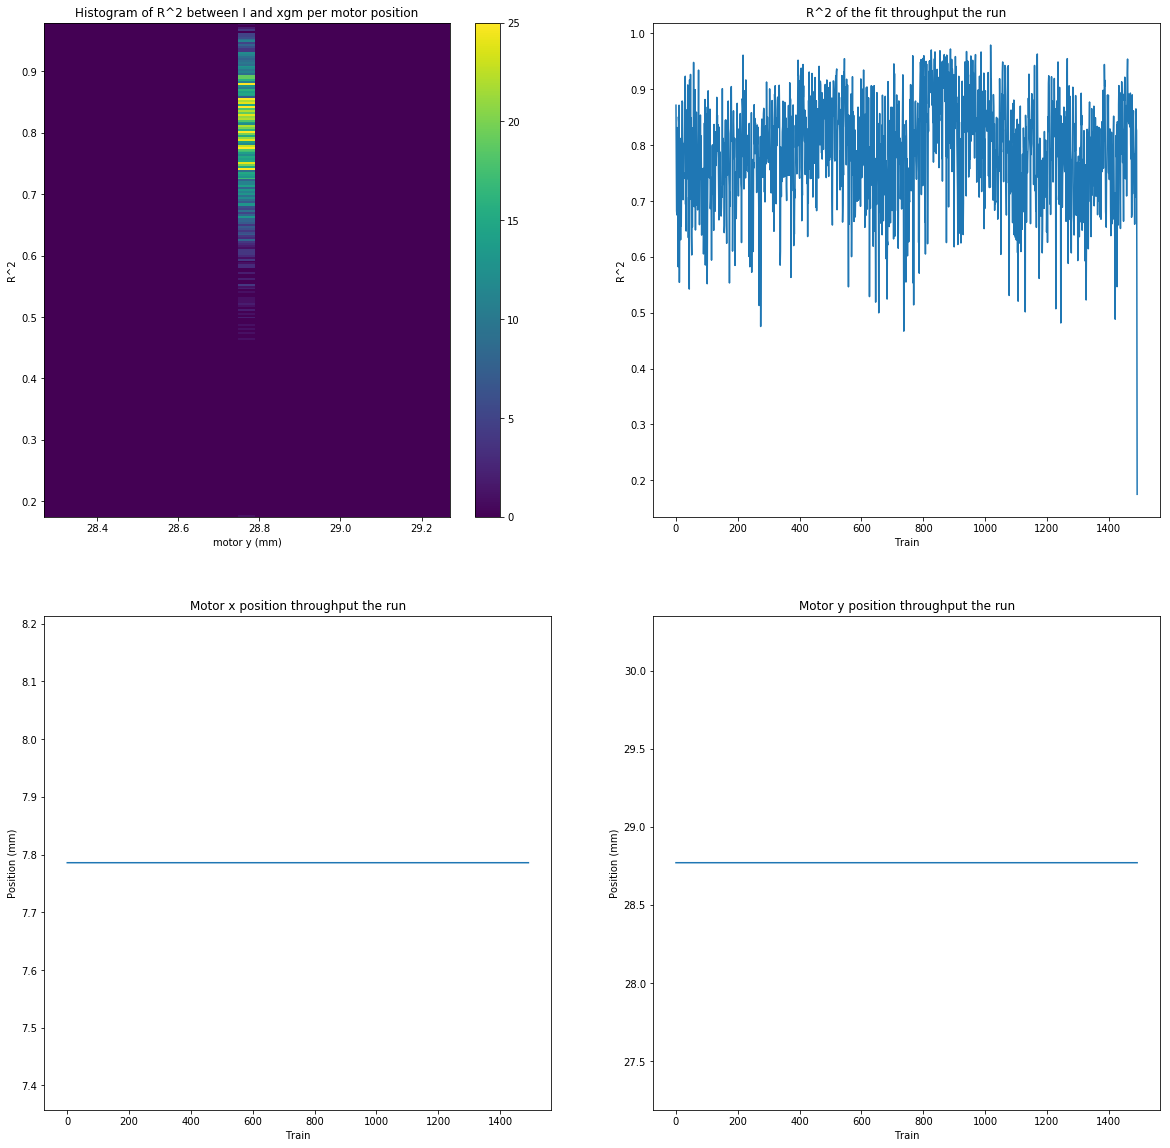

<center><h2> Slope of Fit Analysis</h2></center>

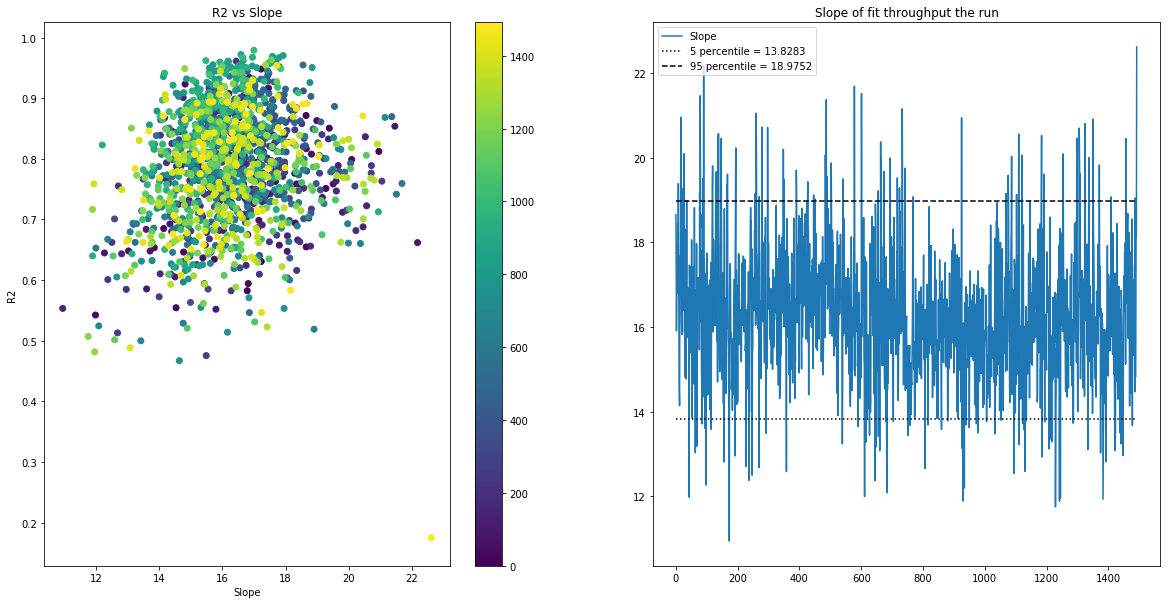

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 193</font></h1>

<center>2917 trains read and synchronized with 44 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

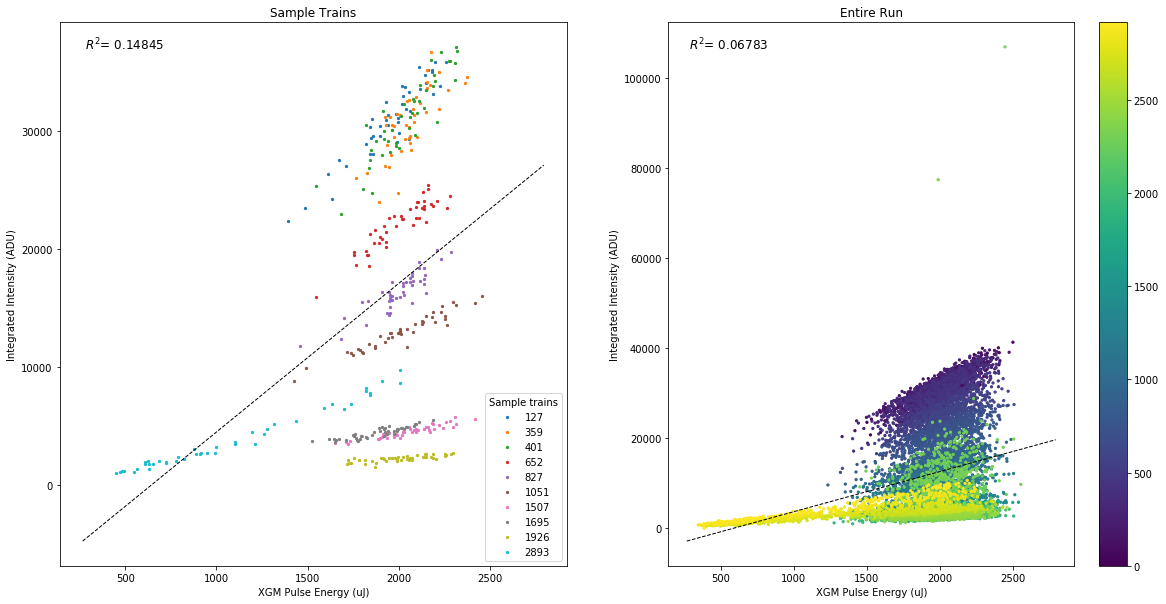

<center><h2> Goodness of Fit Analysis</h2></center>

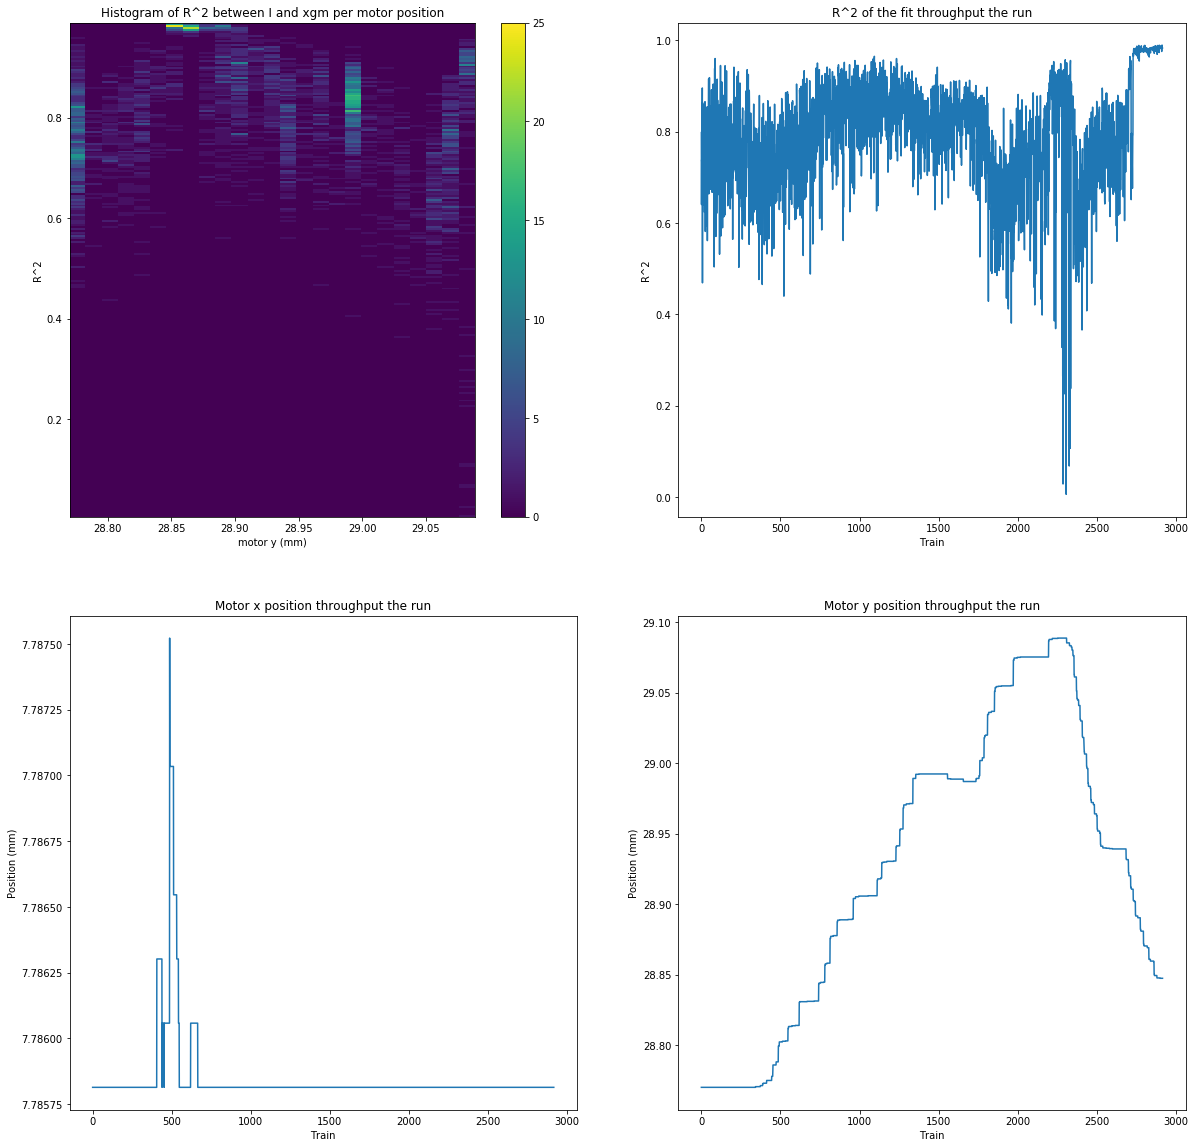

<center><h2> Slope of Fit Analysis</h2></center>

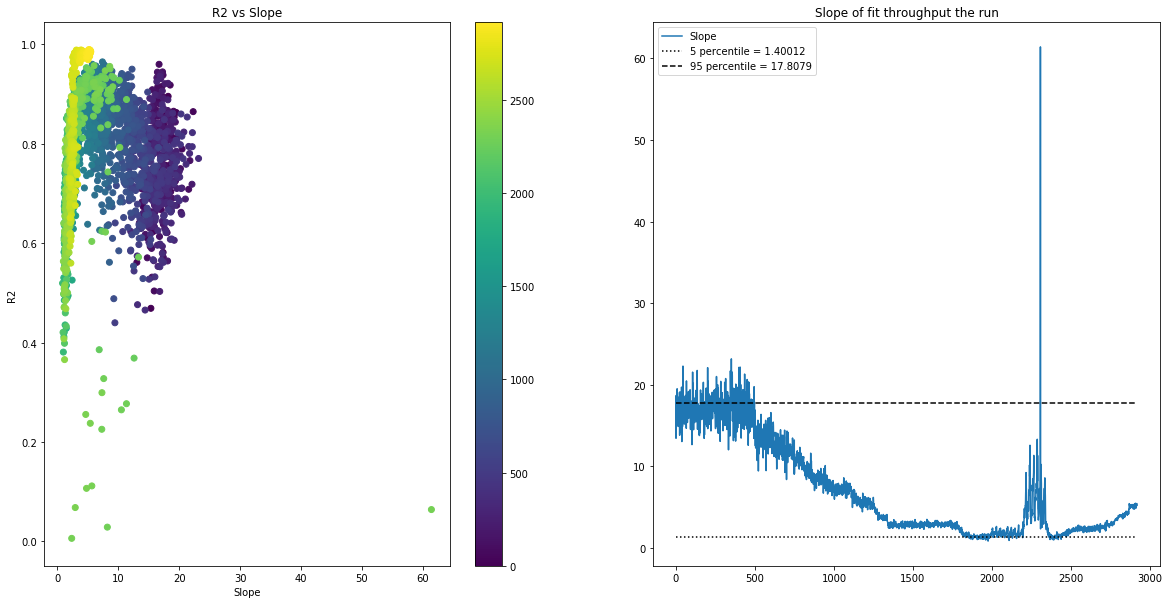

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 194</font></h1>

<center>2588 trains read and synchronized with 44 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

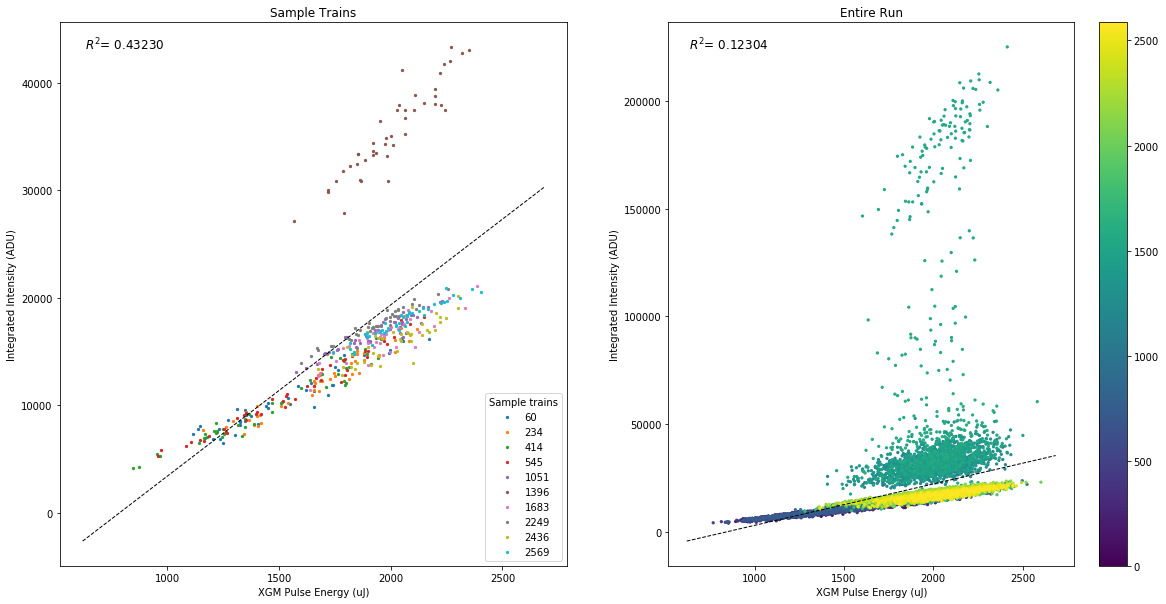

<center><h2> Goodness of Fit Analysis</h2></center>

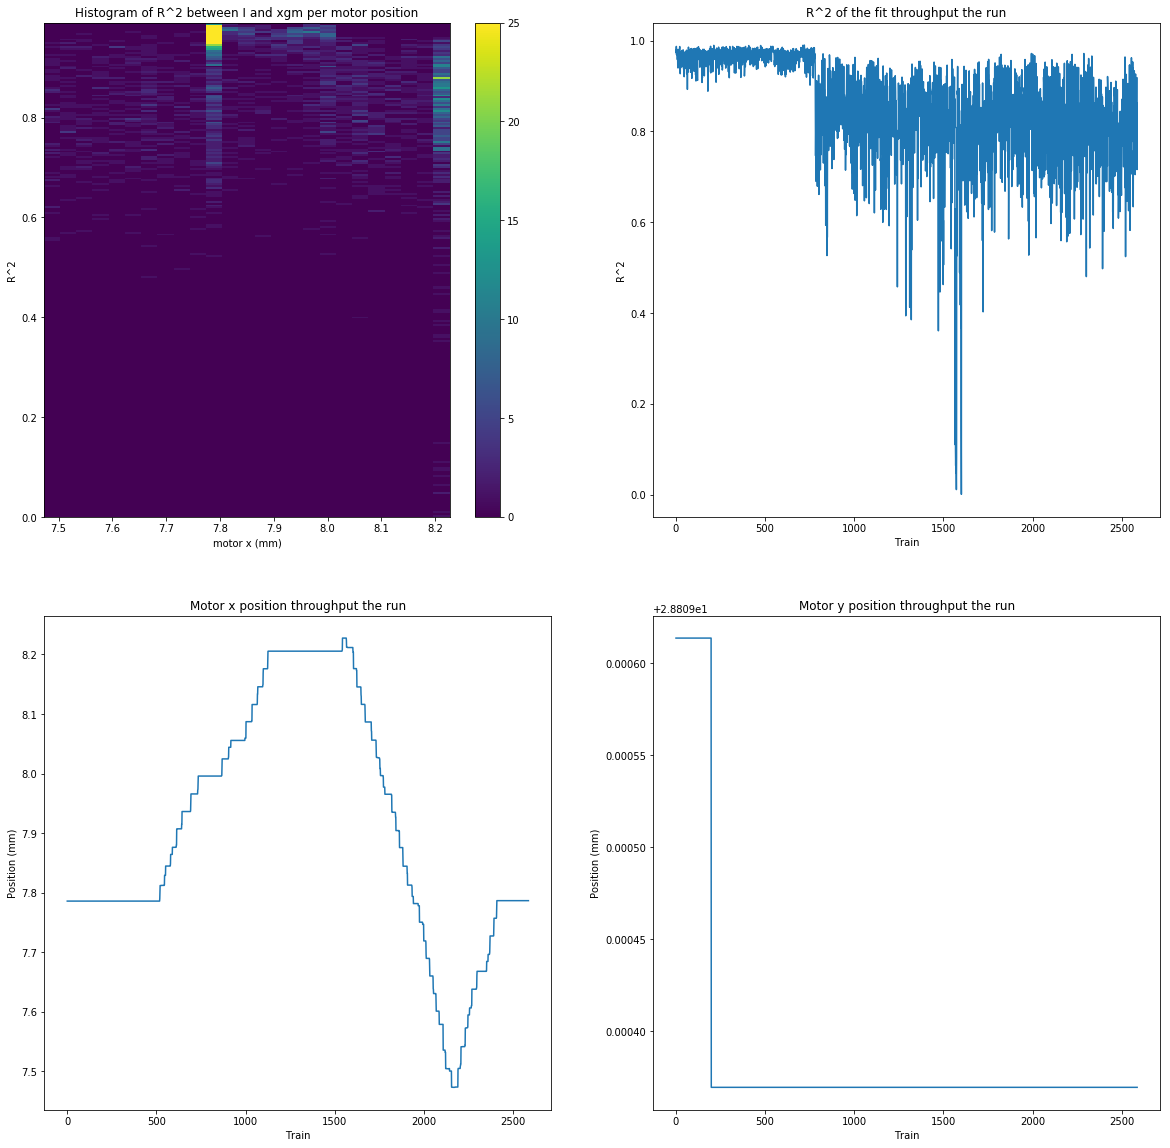

<center><h2> Slope of Fit Analysis</h2></center>

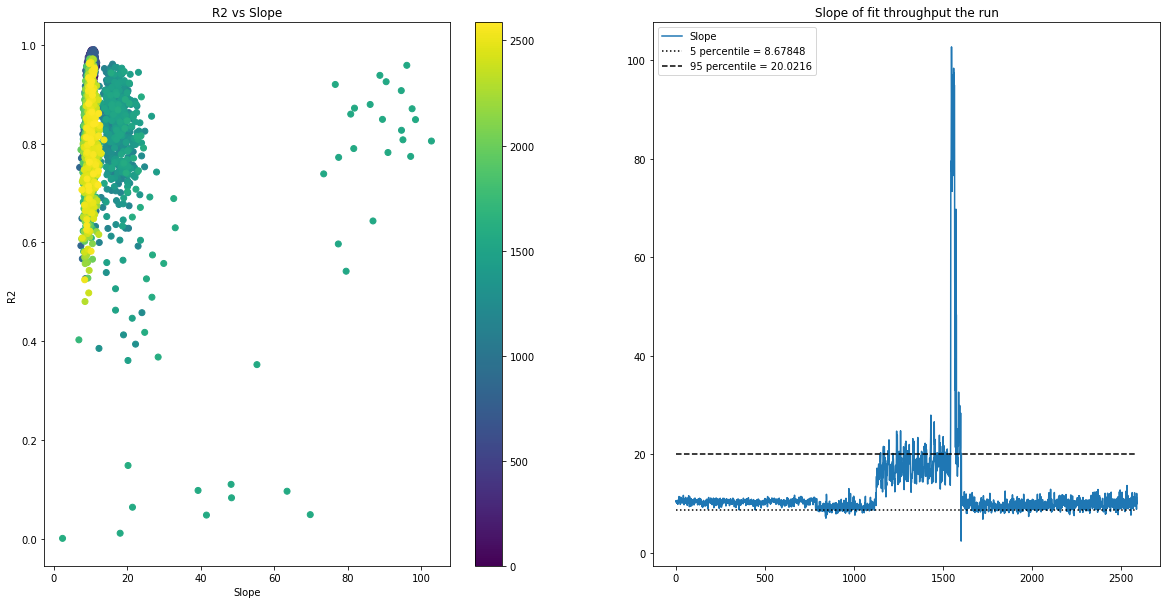

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 195</font></h1>

<center>3122 trains read and synchronized with 176 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

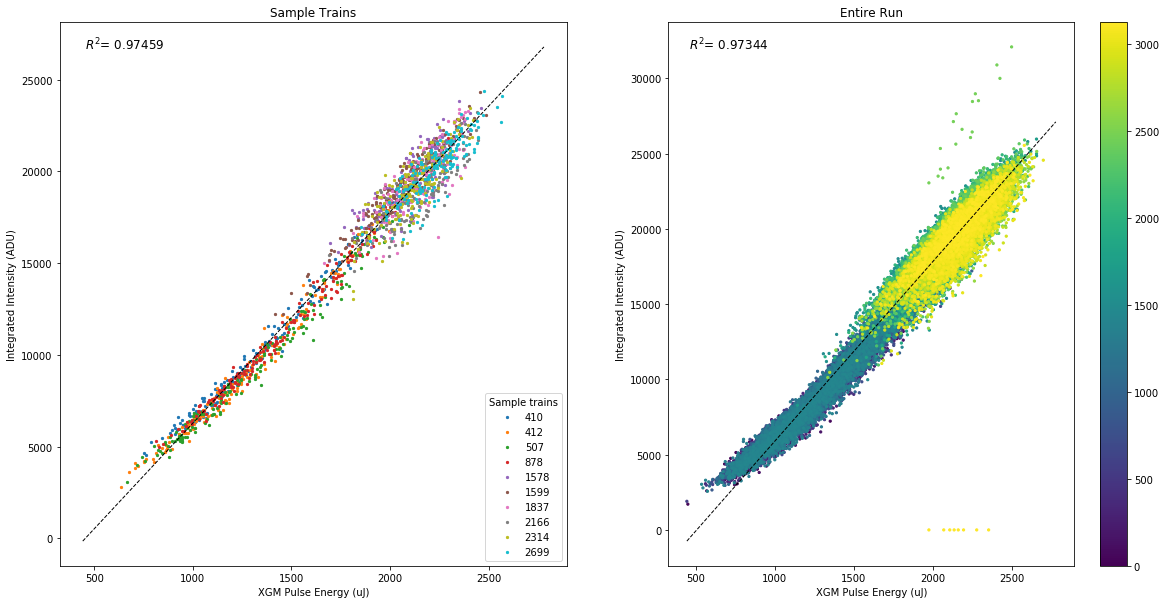

<center><h2> Goodness of Fit Analysis</h2></center>

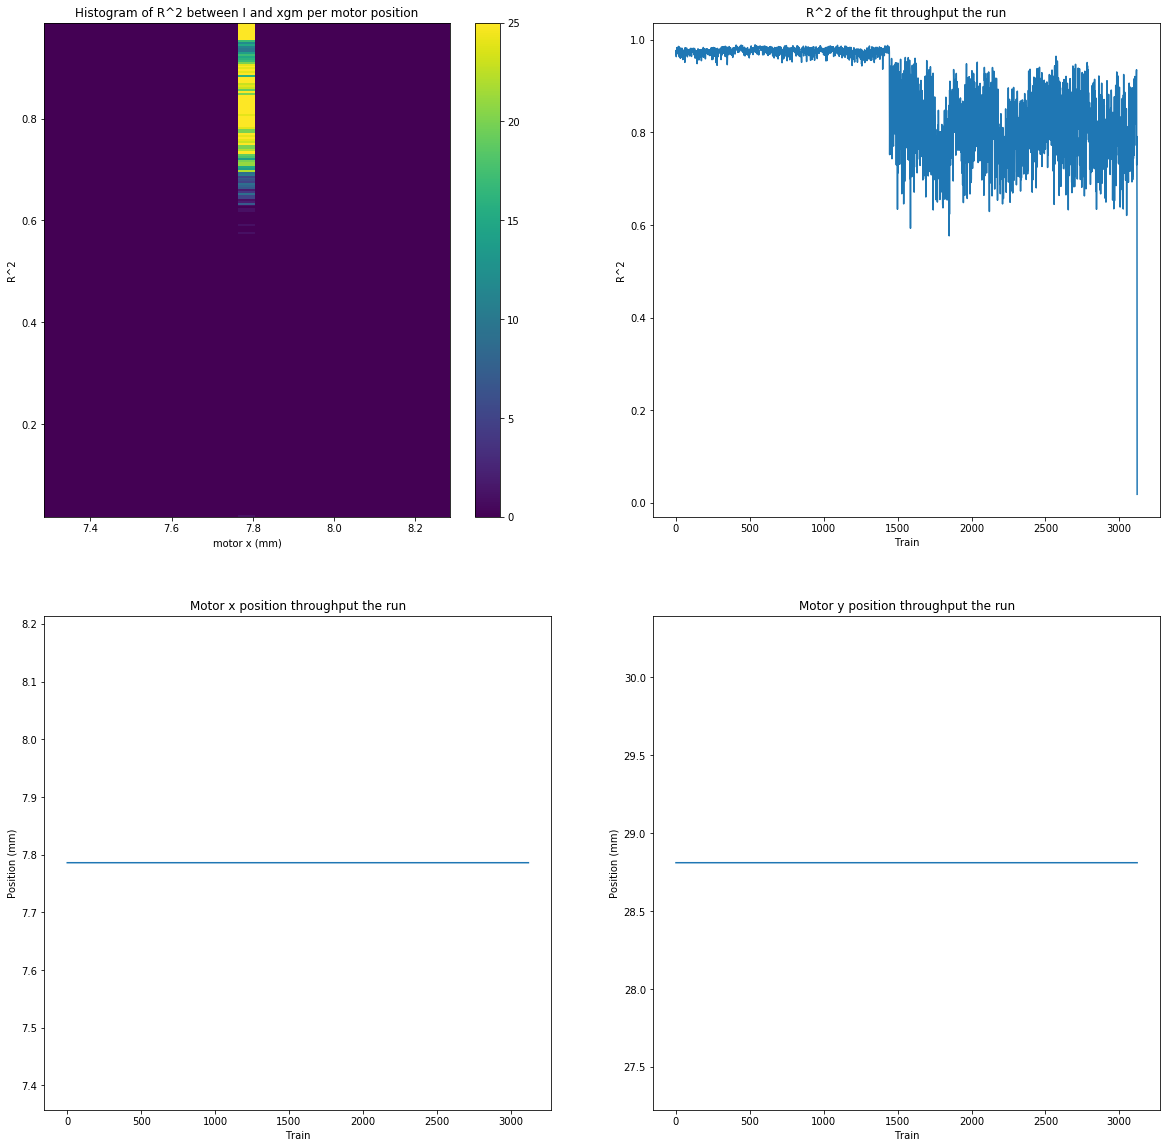

<center><h2> Slope of Fit Analysis</h2></center>

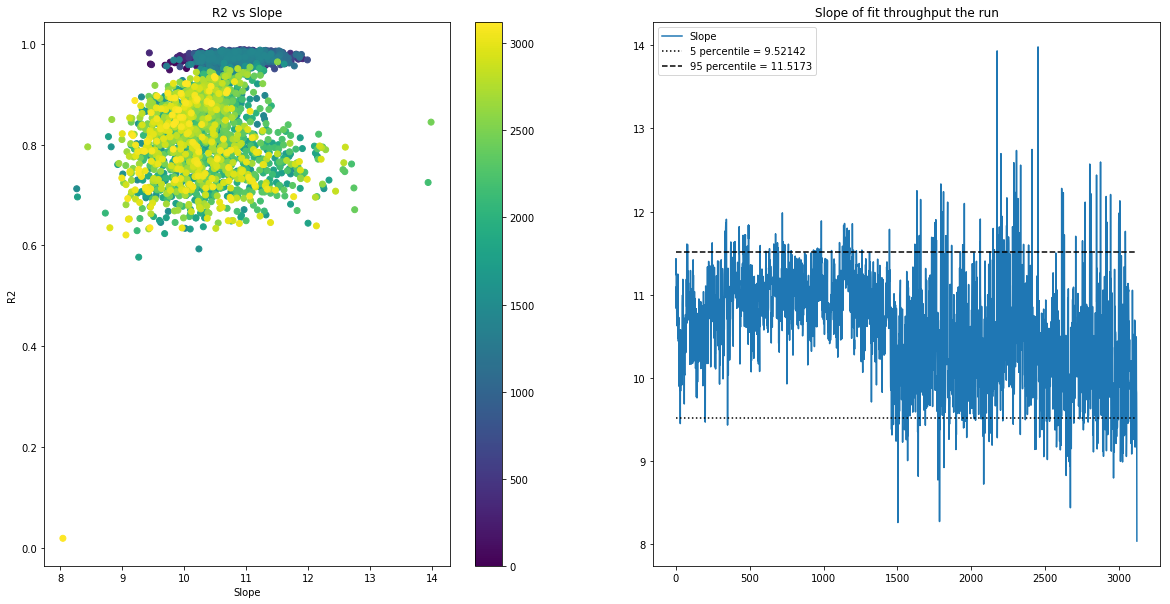

<hr><h1 style="text-align:center"> <font size=32>Analysis of Run 196</font></h1>

<center>1045 trains read and synchronized with 176 pulses per train</center>

<center><h2> Scattered vs Incident Intensity</h2></center>

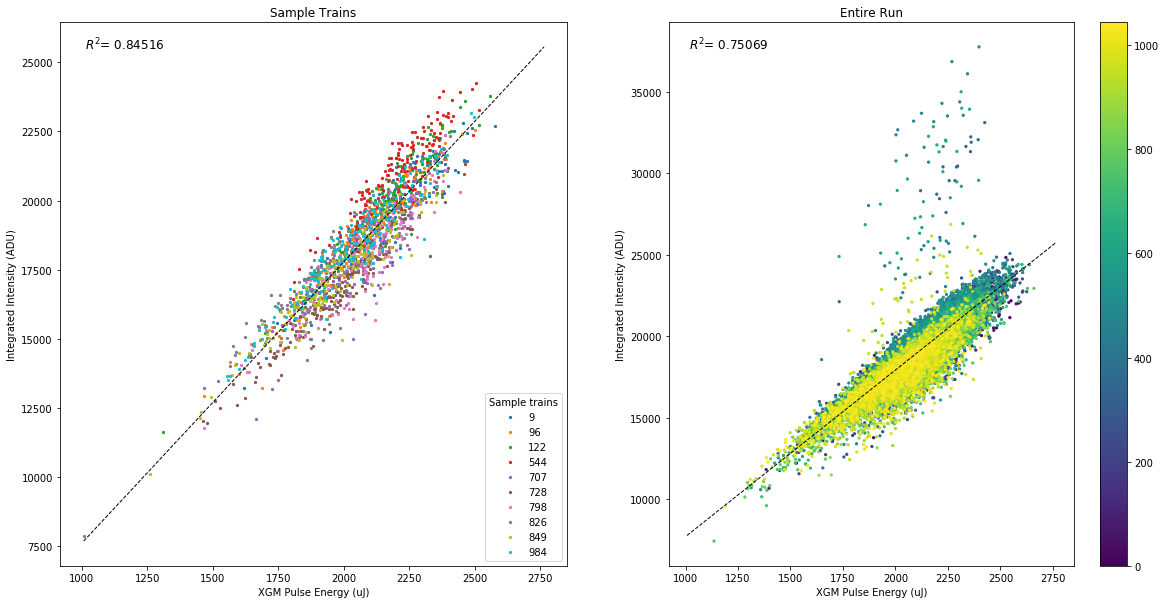

<center><h2> Goodness of Fit Analysis</h2></center>

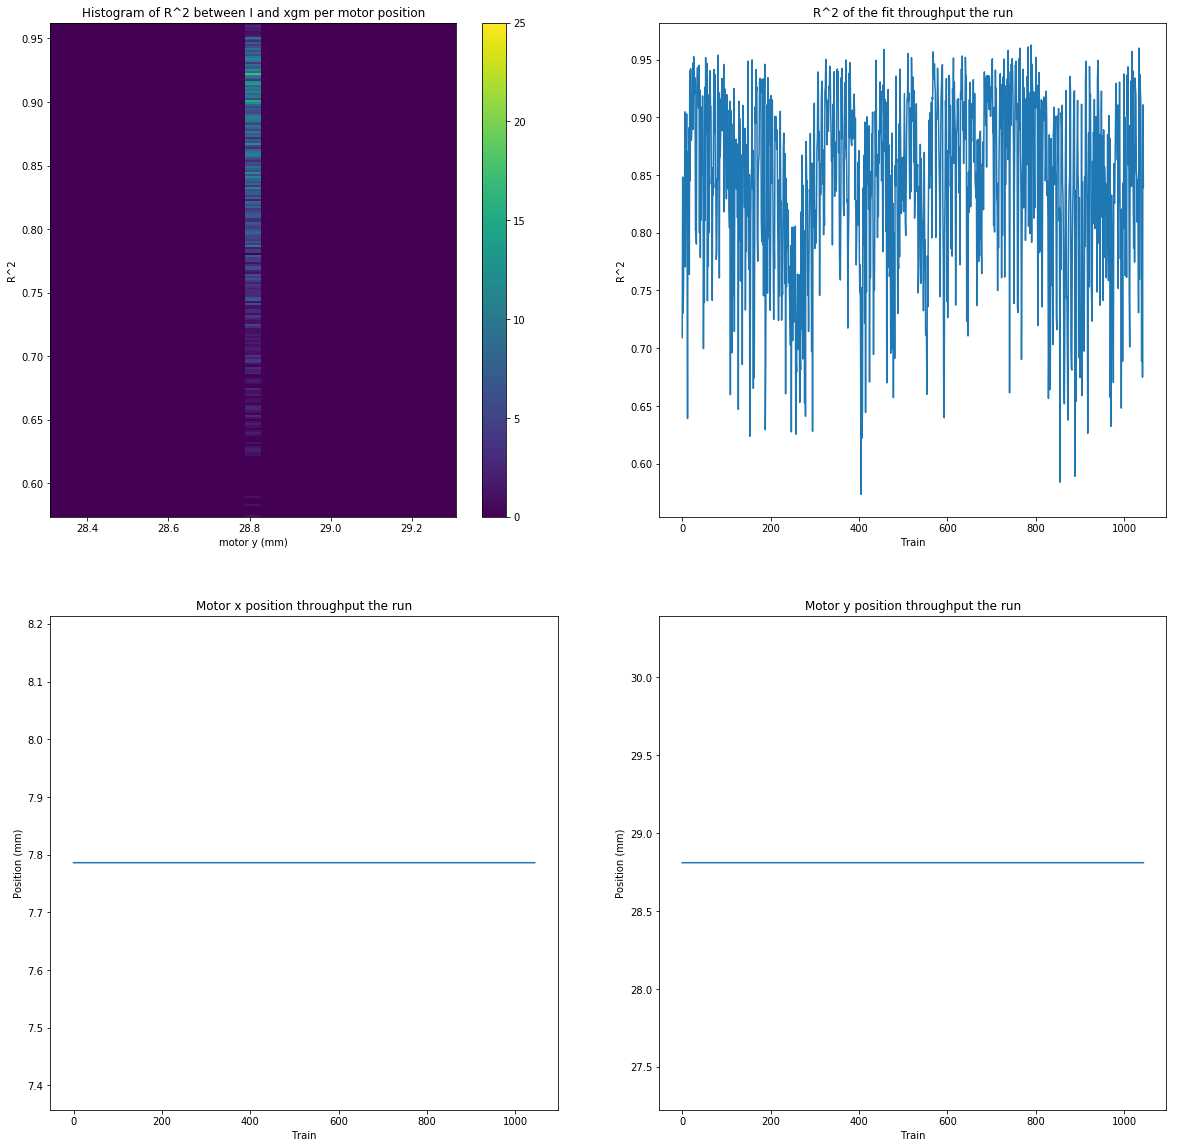

<center><h2> Slope of Fit Analysis</h2></center>

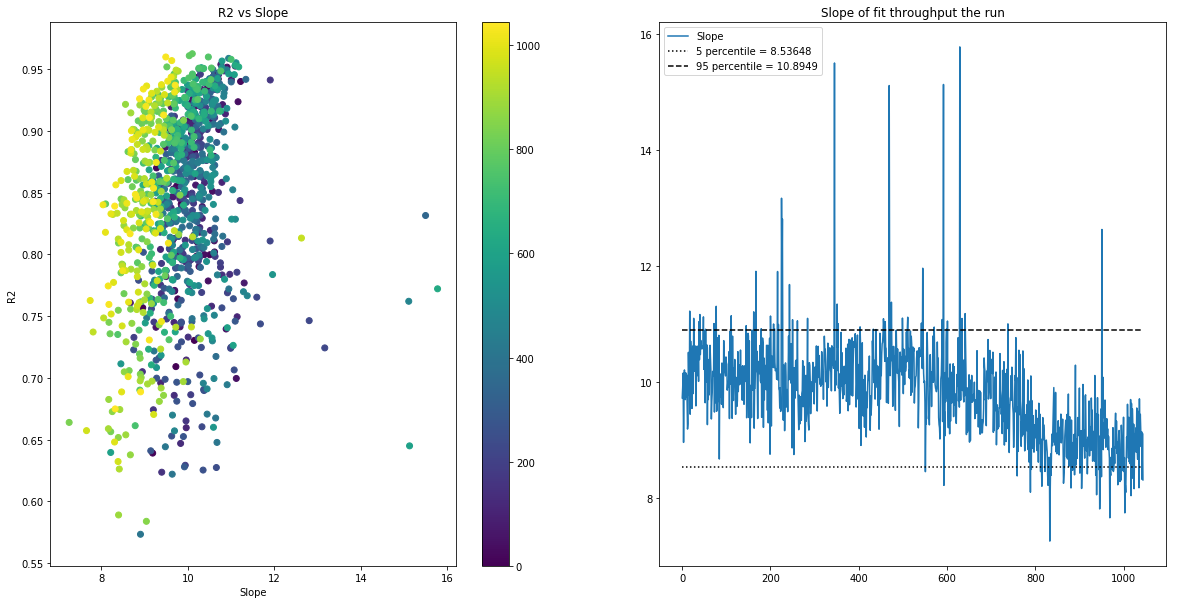

In [706]:
plot_all(np.arange(184,197))

In [707]:
xgm, motor_x, motor_y, radavg = read_run_sync_trains(194)
xgm, radavg = sync_pulses(xgm, radavg)
I = integrate_q_range(radavg)

# of trains:    2588
Duration:       0:04:18.8
First train ID: 1475336442
Last train ID:  1475339029

0 detector modules ()

2 instrument sources (excluding detectors):
  - SPB_EXP_ZYLA/CAM/1:daqOutput
  - SPB_XTD9_XGM/XGM/DOOCS:output

1 control sources:
  - SPB_IRU_MOTORS/MDL/DATA_SELECT

Reshaping of radavg successful: True
Found 2588 common train IDs between radavg and the rest
Train IDs all match: True
Integrating between 0.73-13 1/nm


In [708]:
slopes, intercept, R2 = linear_fit_trains(xgm, I, n=1)

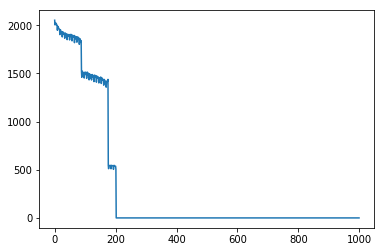

In [695]:
plt.plot(np.nanmean(xgm,axis=0))


In [597]:
slopes, intercept, R2 = linear_fit_trains(xgm, I, n=1)

In [710]:
np.mean(R2[:500])

0.9637932140160398

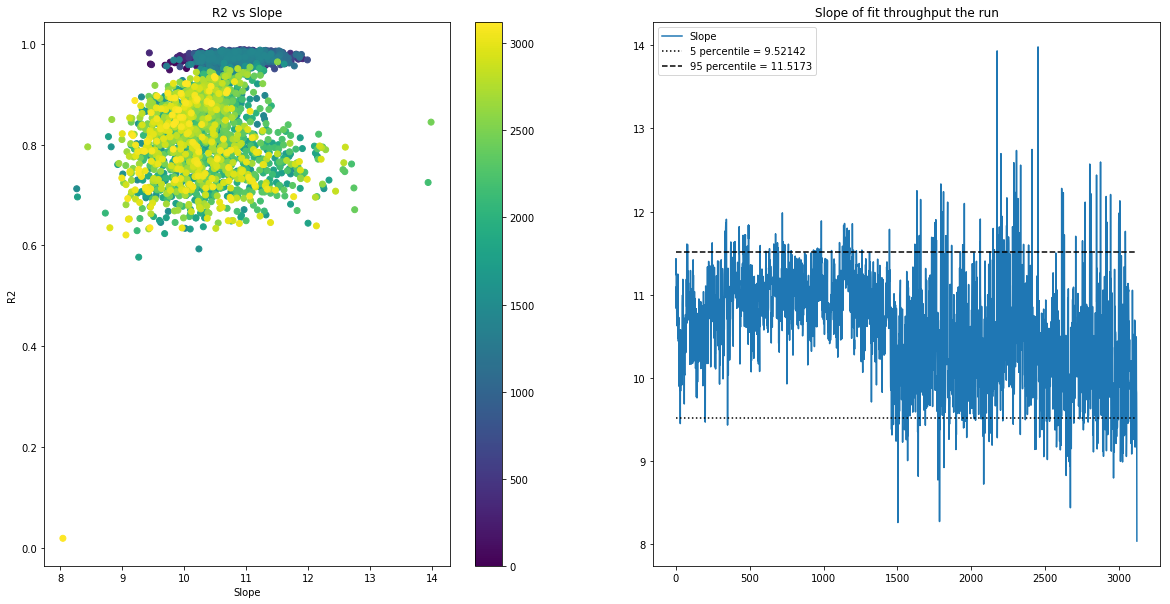

In [599]:
plot_R2_vs_slope(R2, slopes)